# <font color='blue'> Table Of Contents </font>

### <font color='blue'> Problem Statement </font>

### <font color='blue'> Application Architecture </font>

### <font color='blue'> ECS - Create Cluster </font>

### <font color='blue'> Task Definition - Backend </font>

### <font color='blue'> ECS Service - Backend </font>

### <font color='blue'> Task Definition - Frontend</font>

### <font color='blue'> ECS Service - Frontend </font>

### <font color='blue'> ALB for Healthcare Frontend </font>

### <font color='blue'> Testing the application </font>

### <font color='blue'> Deploying Updates </font>

### <font color='blue'> Scaling the application </font>

# <font color='blue'> Problem Statement </font>

In previous lab, we saw how to build and deploy docker images in AWS. But when it comes to deployment and scaling, there were lot of manual steps that needed to be done such as installing Docker, running docker images, stopping and restarting docker container images after deployment, adding new containers while scaling up. These things can be automated in many ways and Amazon Elastic Container Service (ECS) orchestrates most of these things for us. In this lab, we are going to see how to use ECS to deploy and scale our Healthcare Dashboard application.

As such there are no pre-requisites for this lab. But you need to have the same docker images that we created as part of the previous lab. These images should be found in ECR repository. You can do all of these in your AWS Educate account. You can also use a generic AWS account. 

# <font color='blue'> Application Architecture </font>

The architecture remains same as previous lab. We are just deploying the containers to EC2 instances using ECS instead of manually. The EC2 instances are registered with ECS Cluster and hence ECS is able to orchestrate the deployment and scaling on behalf of us.

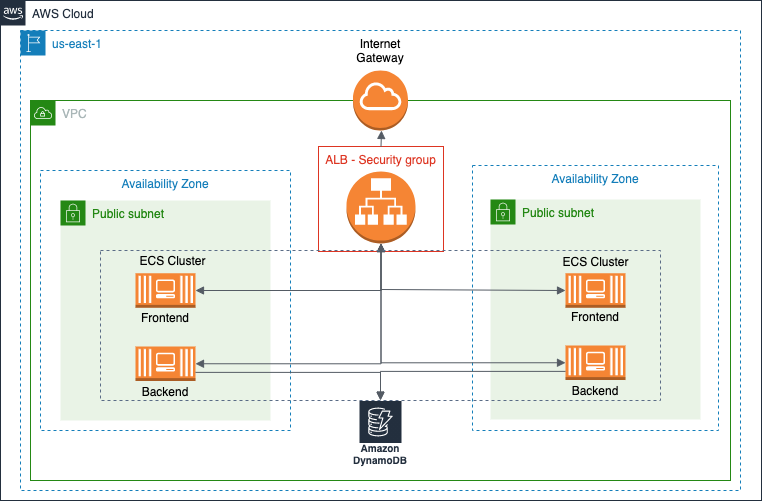

# <font color='blue'> ECS - Create Cluster </font>

In this step, we are going to create an ECS cluster. ECS Cluster is a logical group of EC2 instances. EC2 instances run the ECS agents as docker containers (as a side car). ECS agents register the instance to the ECS Cluster. Please follow the below steps to create a ECS cluster.

1. Search for ECS and click on `Elastic Container Service` in the search result. On the left pane, click on Clusters under Amazon ECS. After that, click on Create Cluster button.

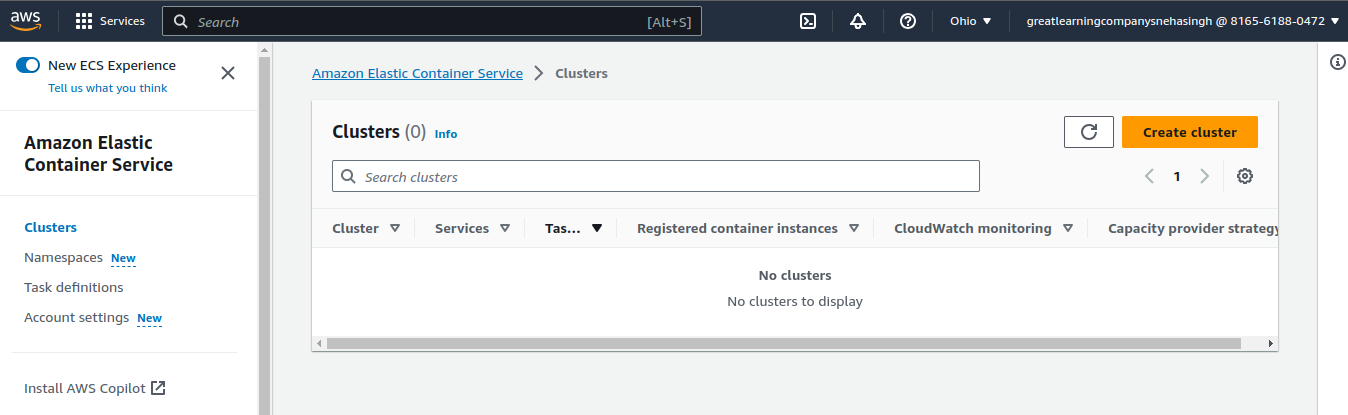



2. In the next page, enter the cluster name as `HealthcareDashboardCluster`.

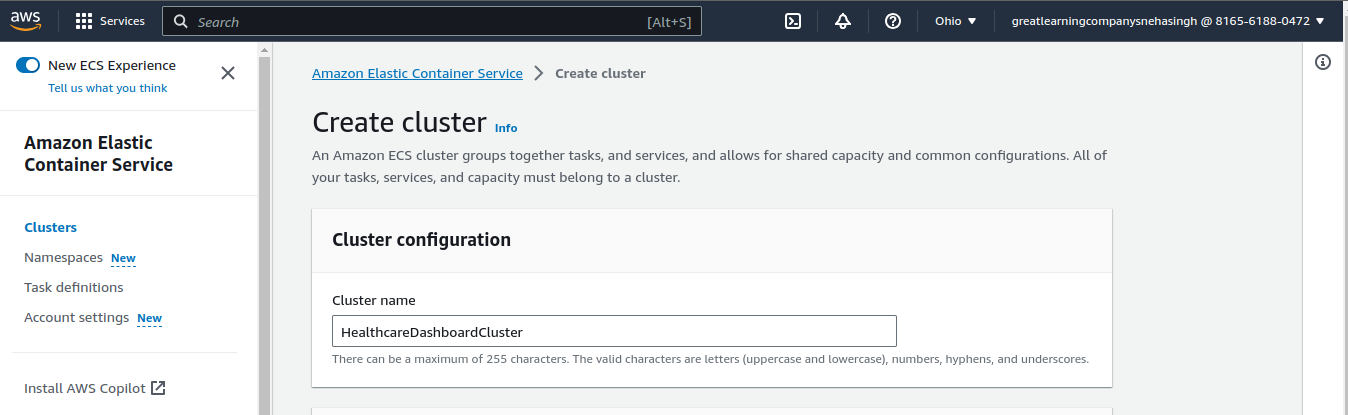



3. In networking, we will use the existing default VPC for the purpose of this lab. But in real world scenario, you would create ECS Cluster in a private subnet and then expose it using ALB in a public subnet. Select 3 subnets from the dropdown to provide high availability. 

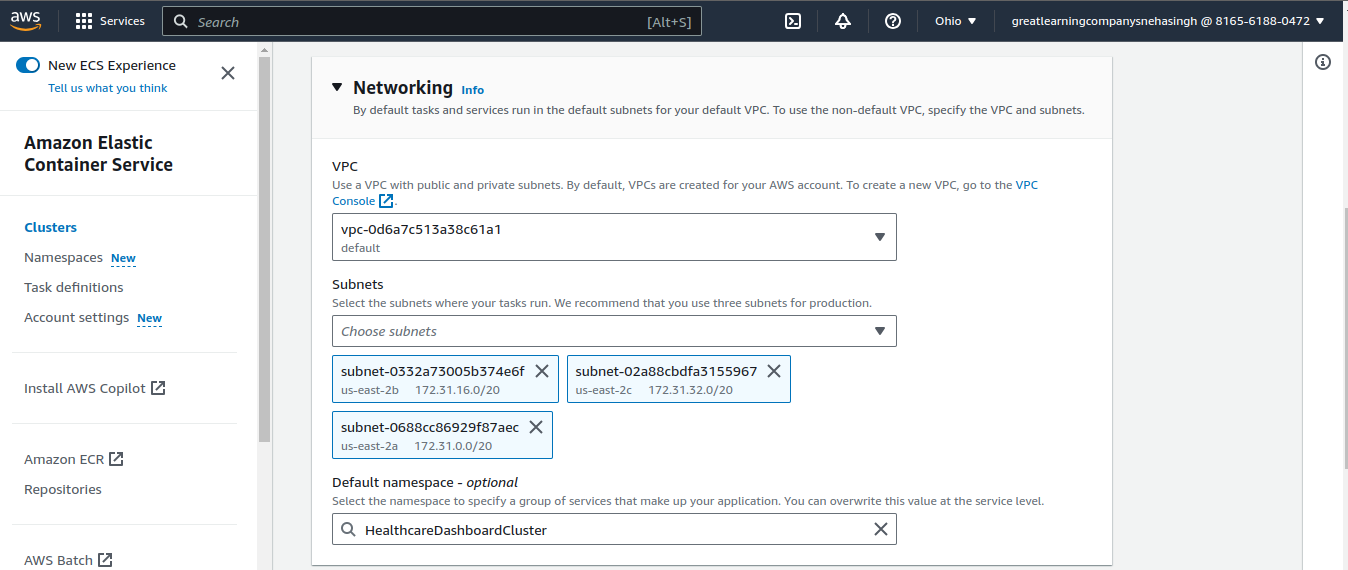


4. In Infrastructure, please select `Amazon EC2 Instances` option. We are going to deploy our application in EC2 as a container. ECS fargate is a serverless option and we are not going to use that for our lab. Select the operating system and Instance type as Linux 2 and t2.micro respectively for this lab. Set maximum number of instances as 2. Select the key pair to SSH into these EC2 instances if need there be. Leave rest of configurations as default and click on create button at 

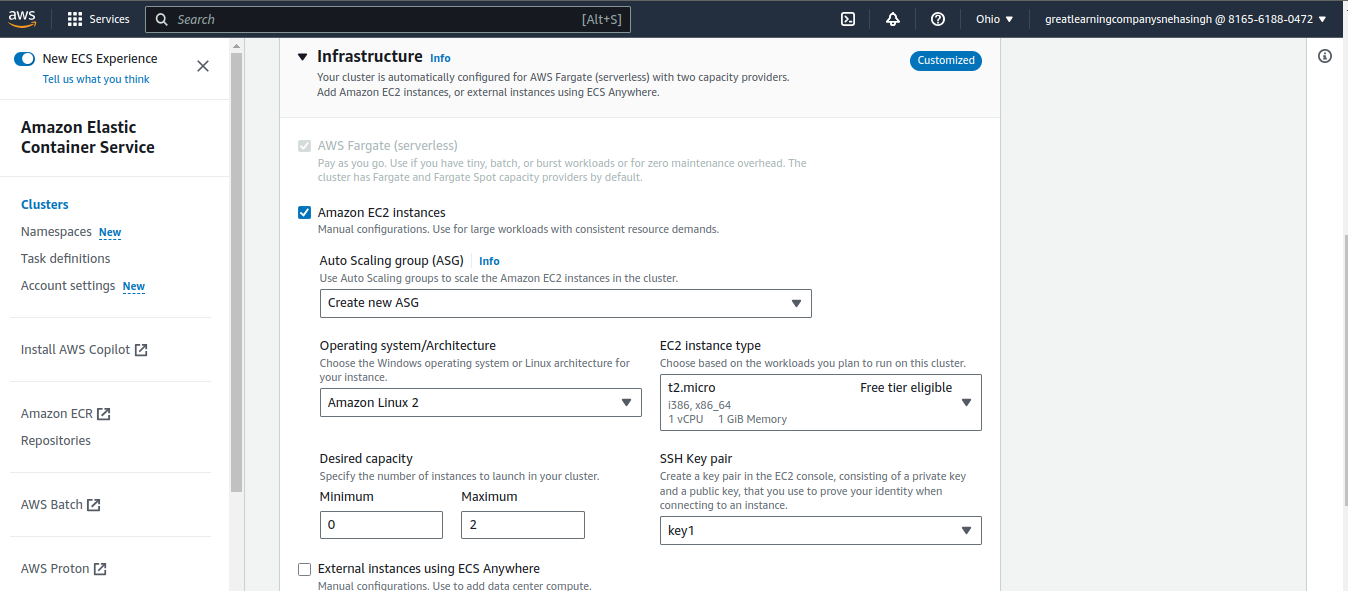


5. Once created, we should be able to see the cluster.

# <font color='blue'> Task Definition - Backend </font>

In this step, we are going to create task definition. It is metadata in JSON format that tells ECS how to run a Docker container. It contains certain critical information such as Image name, port binding, memory/cpu requirements, etc.

Please follow the below steps to create a new task definition.

1. Inside ECS, click on ```Task Definitions``` on the left pane. Click on the ```Create new task definition``` button and select create new task definition.

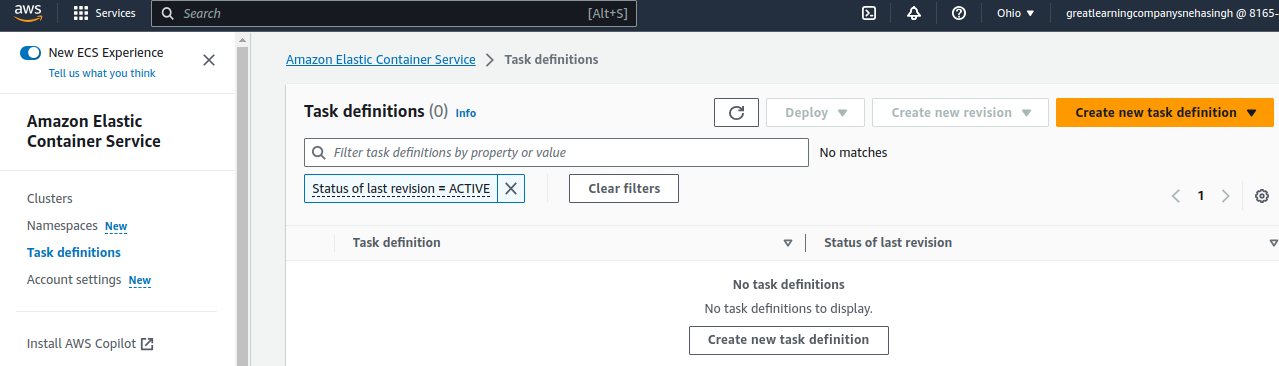


2. Give the name for the task definition configuration as ```HealthcareServiceTaskDefinition```. Select Amazon EC2 Instances as Infrastructure. As mentioned earlier, we are using EC2 to deploy our application. Leave instance configurations as default for this lab.

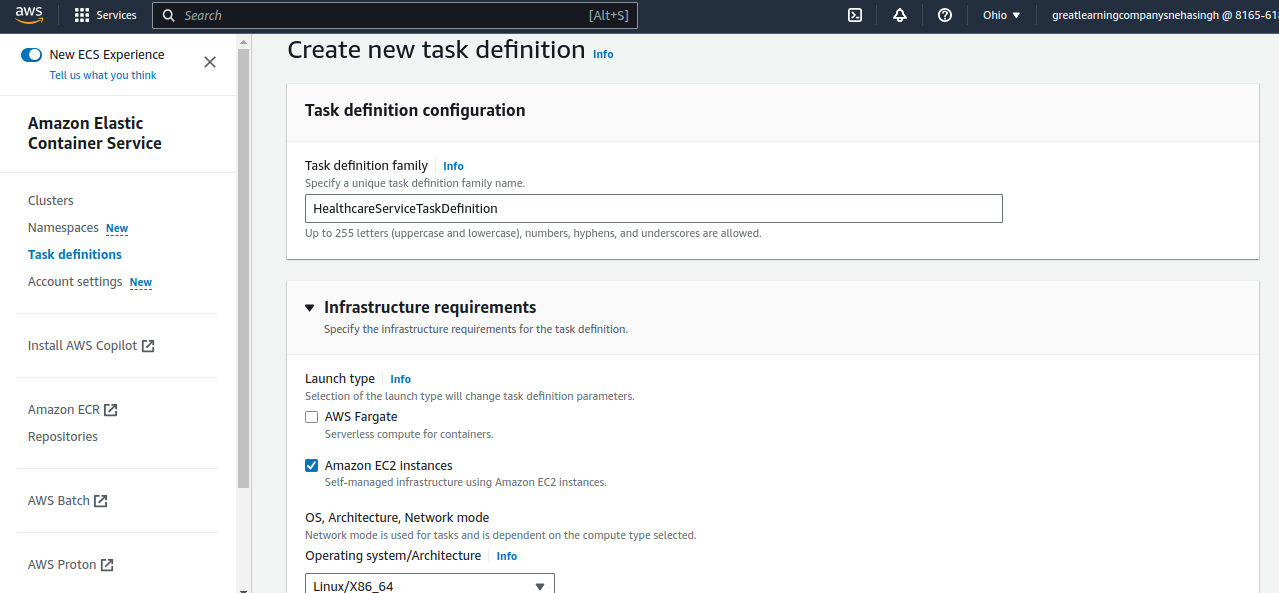


3. We need to create a new Task Role in IAM which would allow our tasks to call DynamoDB to fetch data, so click on `IAM Console` link on the top right of the Task Role input box.

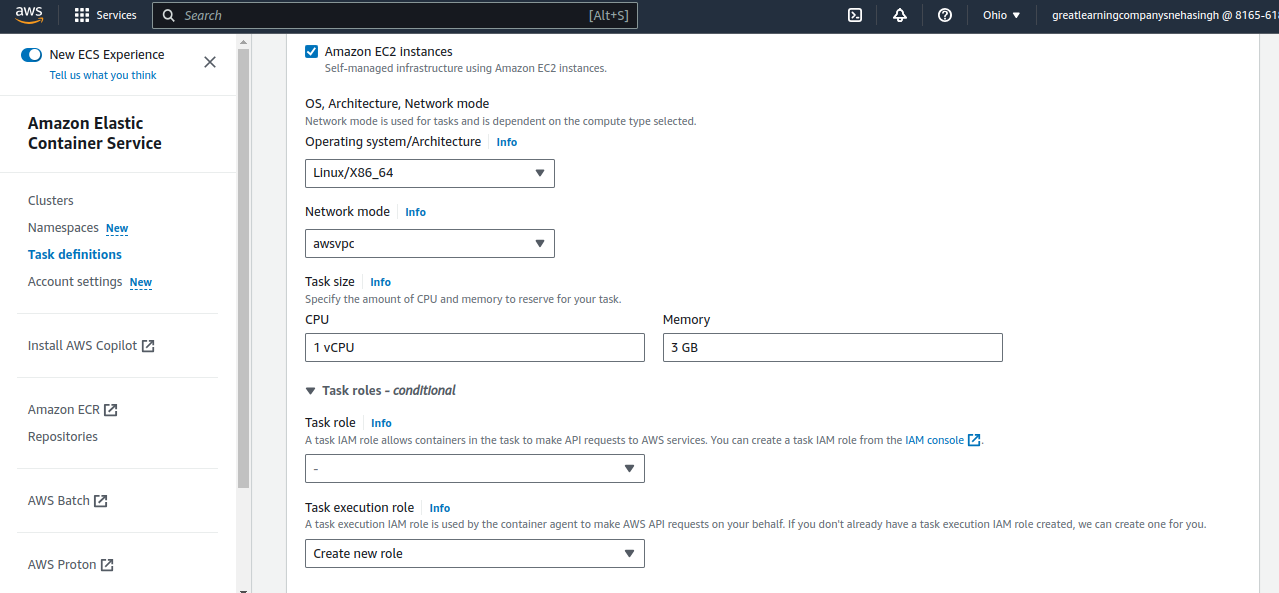


4. Once you go to IAM Roles page, click on Create Role button. In Select type of trusted entity, go to the dropdown at the bottom to choose a service to view use case and select Elastic Container Service.

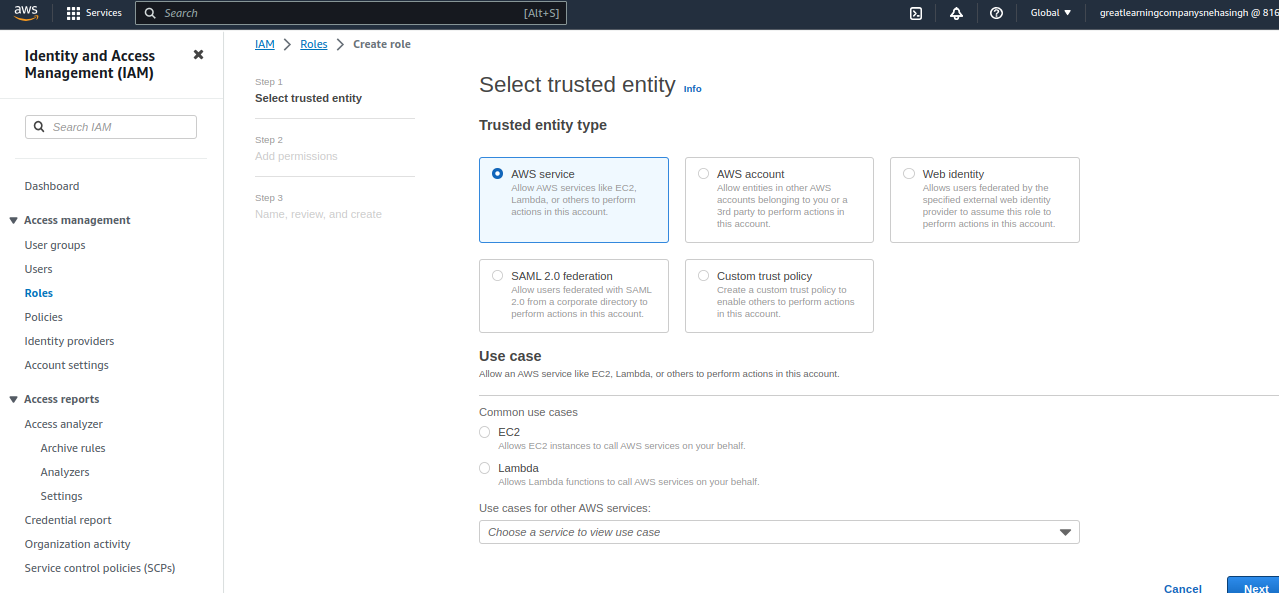

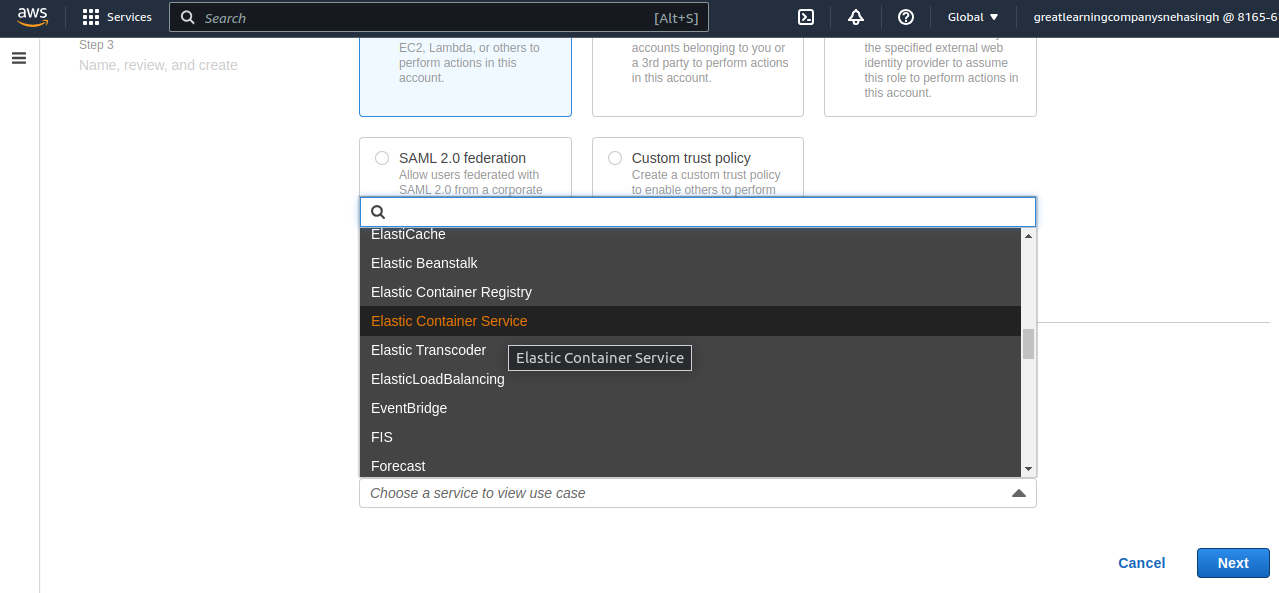


5. In select your use case, please select Elastic Container Service Task and then click on Next button.

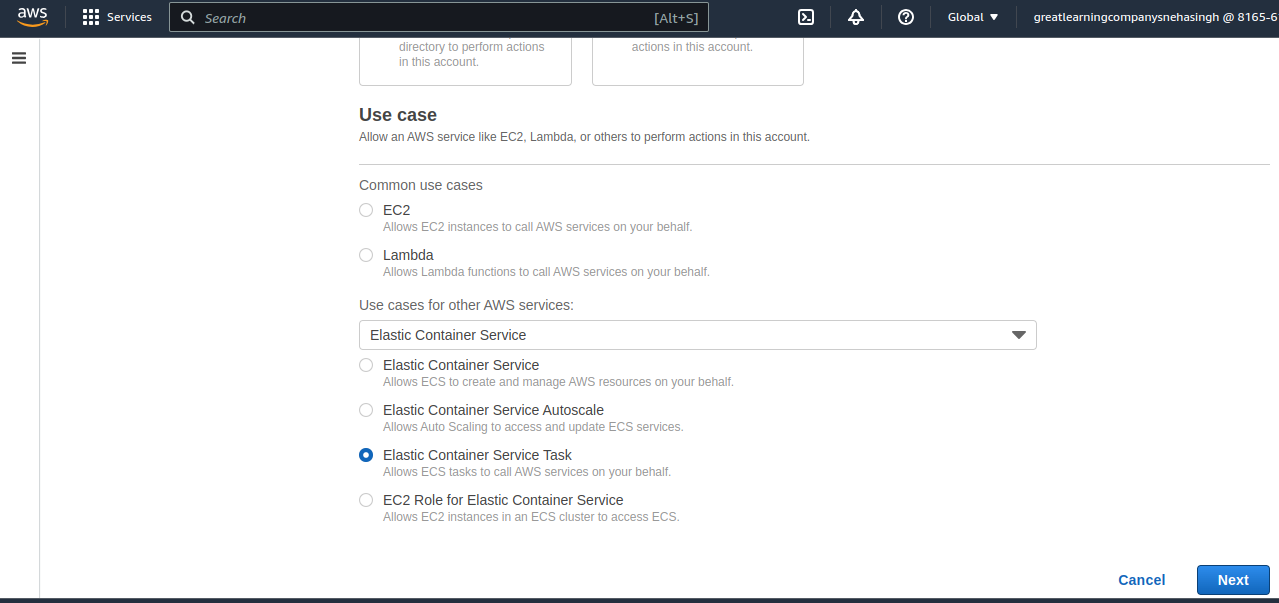


6. In attach permissions policies, search for dynamodb and select `AmazonDynamoDBFullAccess` and click on Next button.

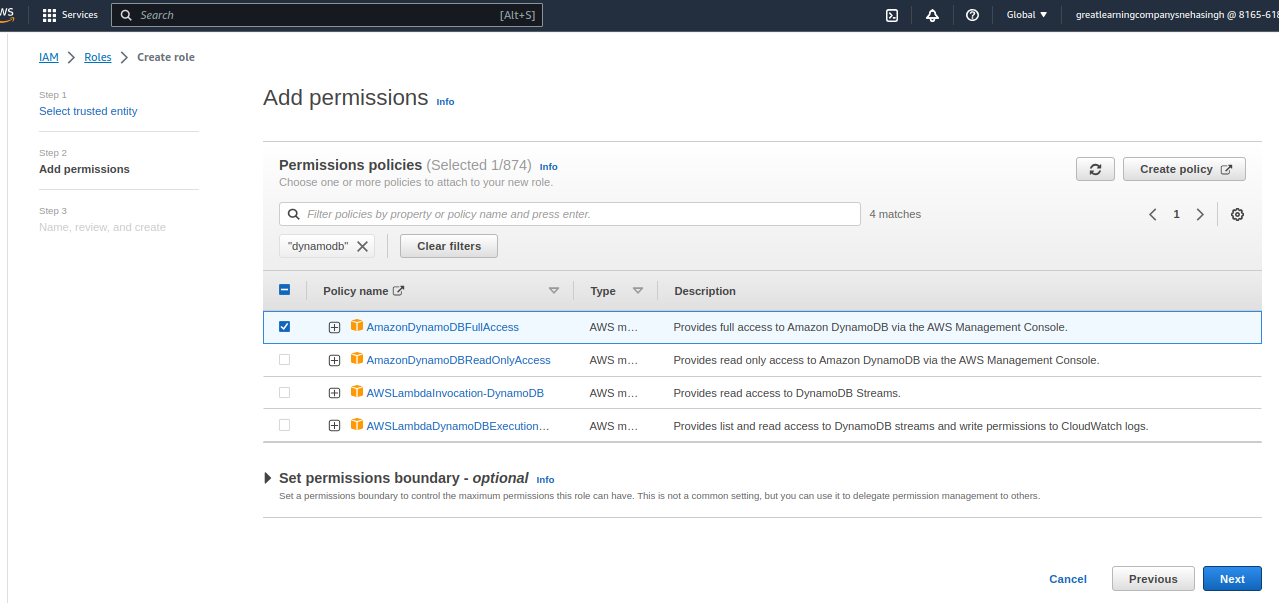


7. Enter name as `ECSHealthCareServiceTaskRole`, leave others as default and click on Create role button.

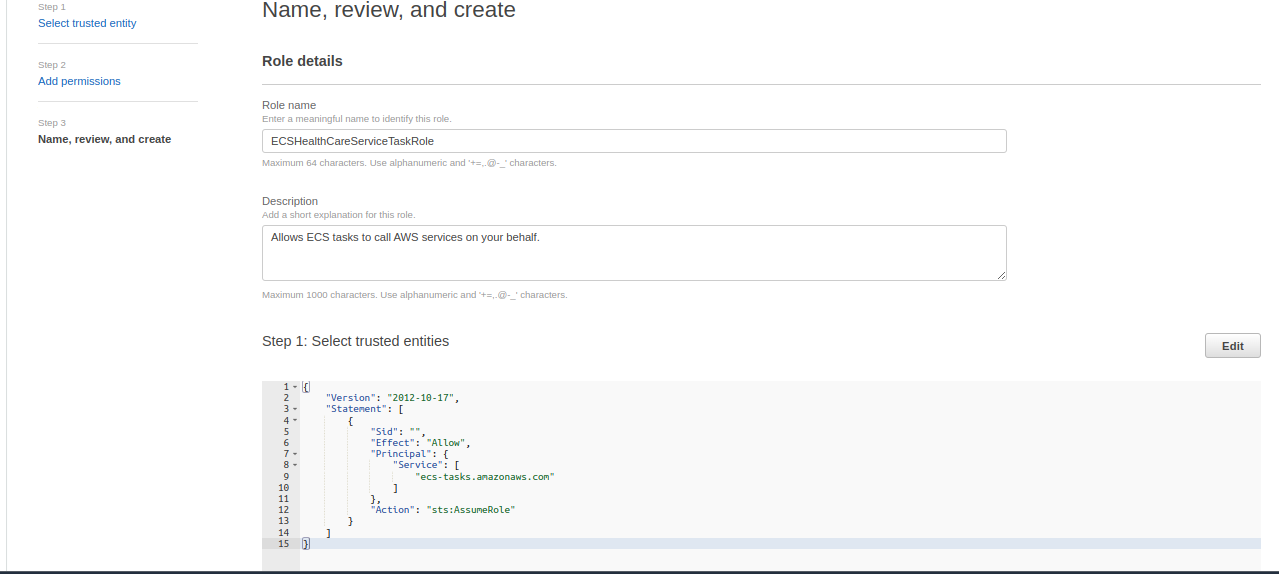

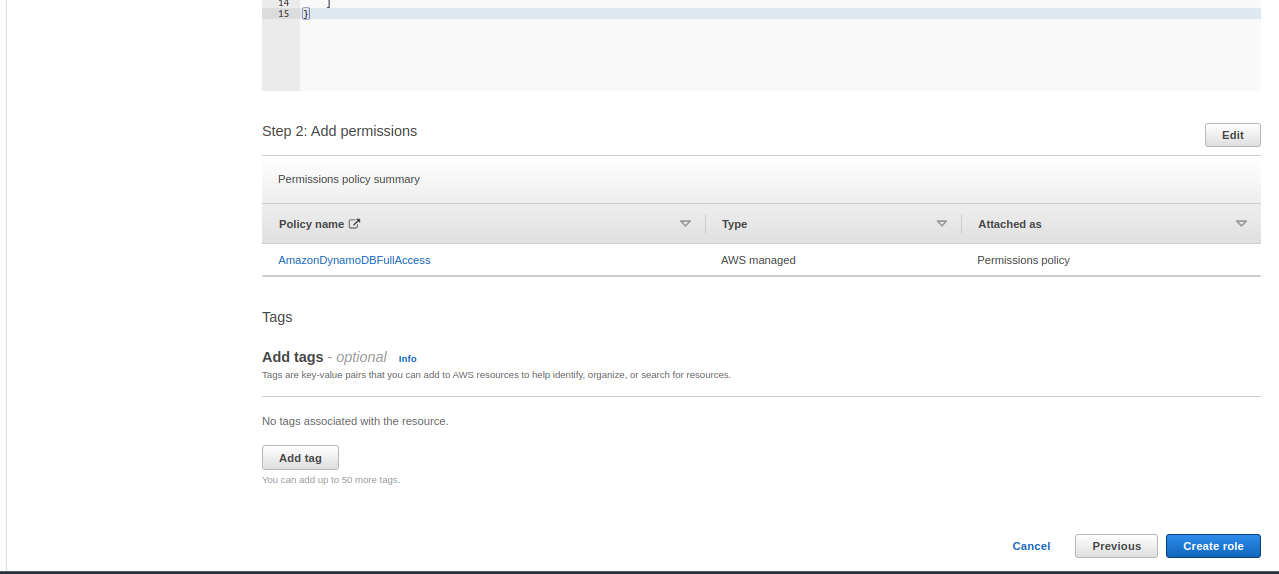


8. Now, we can go back to our previous window where we were configuring Task Definition and select the Task Role that we created in previous step. Name should be `ECSHealthCareServiceTaskRole`.

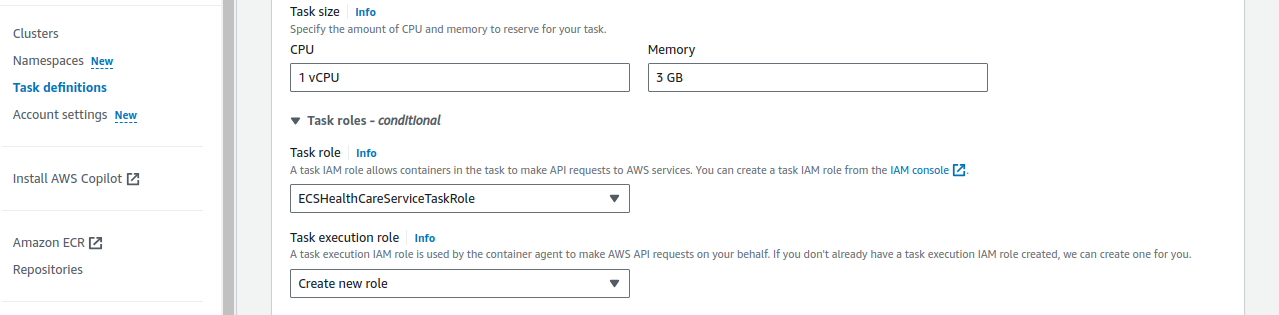


9. On the Container Definitions section, click on Add Container button. Enter the name as `HealthCareServiceContainer`. Enter the URL of the container image from the ECR. It should be something like this `(AWSAccountId).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest`. Go to resource allocation limits and enter the hard limit as 0.128. This will make sure our container wont use more than 128 MB of memory. In port mapping, enter Container port as 8080. This is because our service will be running in 8080 in the container. ECS will use a dynamic port mapping based on the availability of ports on the host machine.


10. You can leave everything else with default values/selection. And then click on Create button. Once created, you should be able to see the created task definition like below.

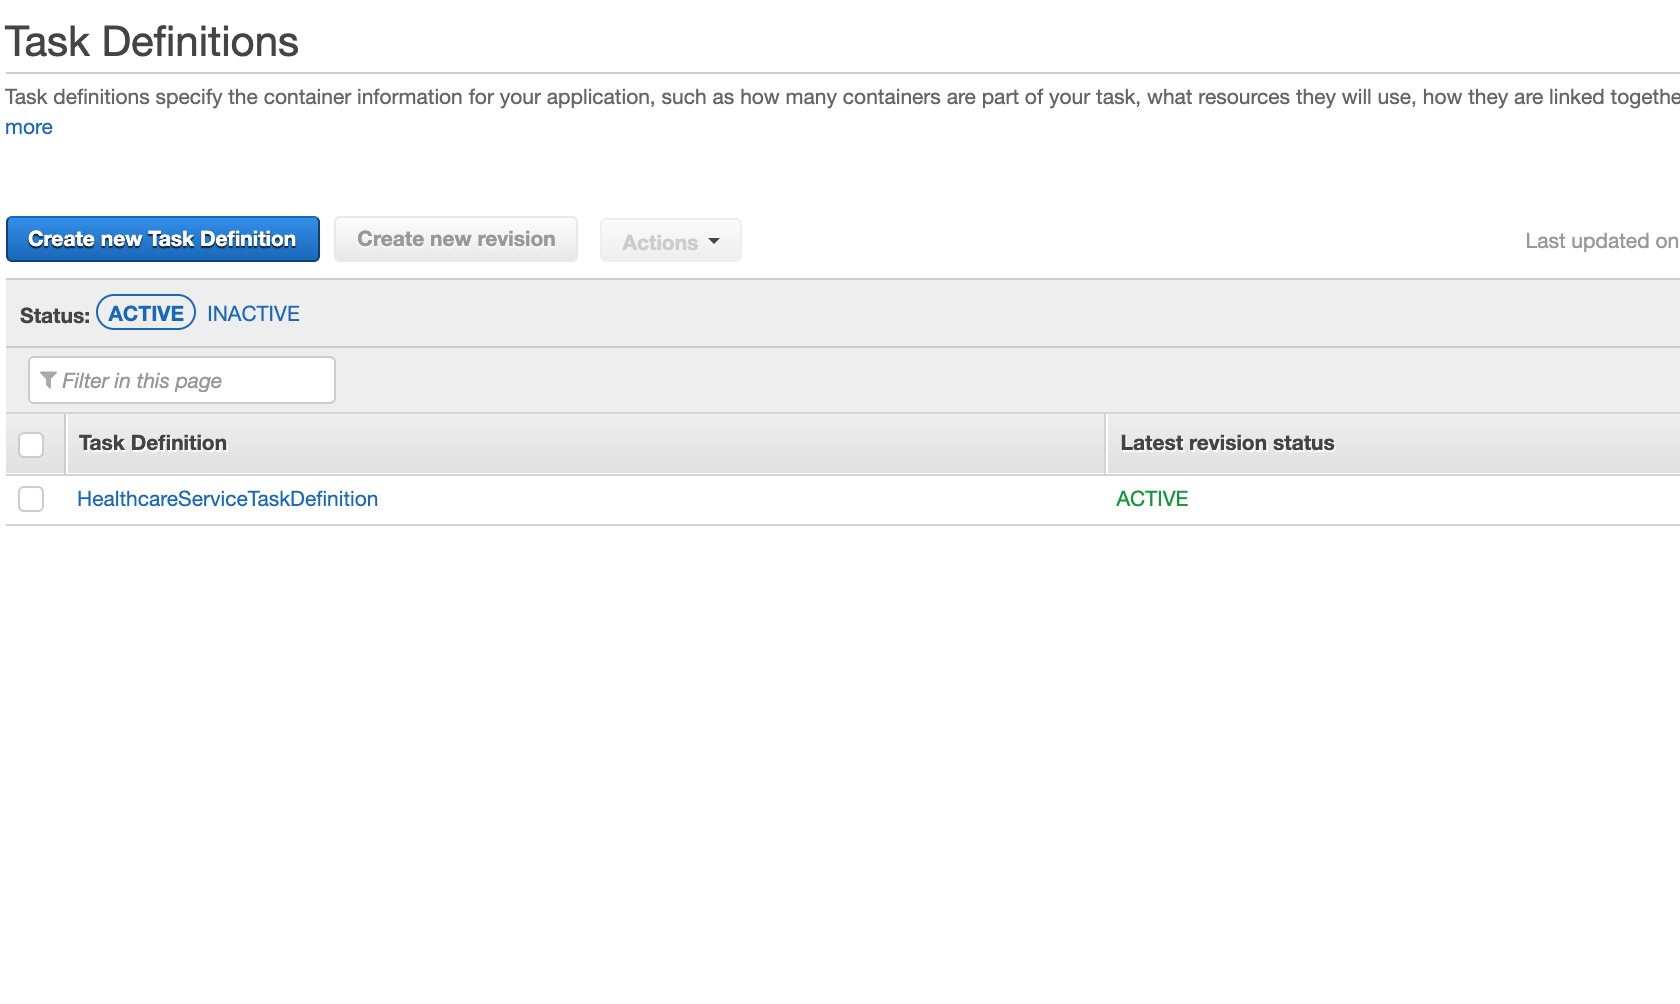

# <font color='blue'> ECS Service - Backend </font>


Steps shown below are performed on the previous AWS user interface. You can switch to the new AWS interface by selecting the toggle option on top left corner of the AWS console as shown below. 

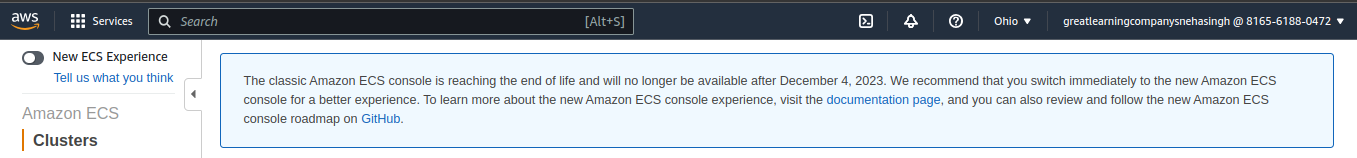


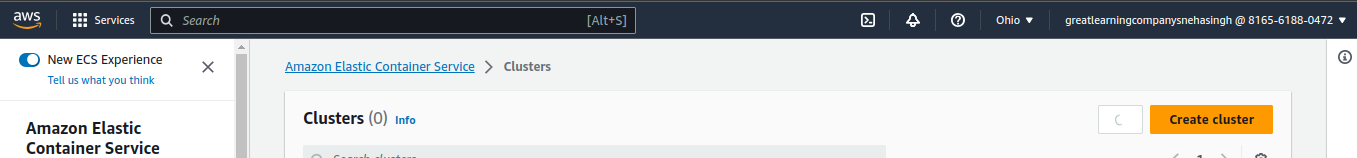


In this step, we are going to create a ECS Service. ECS Service helps define how many tasks should run and how they should be run. ECS Service ensures that the number of desired tasks are running across our fleet of EC2 instances. It can be linked to ELB/ALB/NLB if required. You can run tasks without ECS Service as well. Let's see how to create a service in ECS.

1. Go inside the ECS cluster that we created and click on Create button in Services tab.

2. In the next screen, please select EC2 as the launch type, select the task definition that we created in the previous step. Enter the name as `HealthcareECSService` and number of tasks as 2 since we want to start with 2 containers running. Select the service type as Replica and enter all the other details as in the below screenshot. Click on Next button when done.

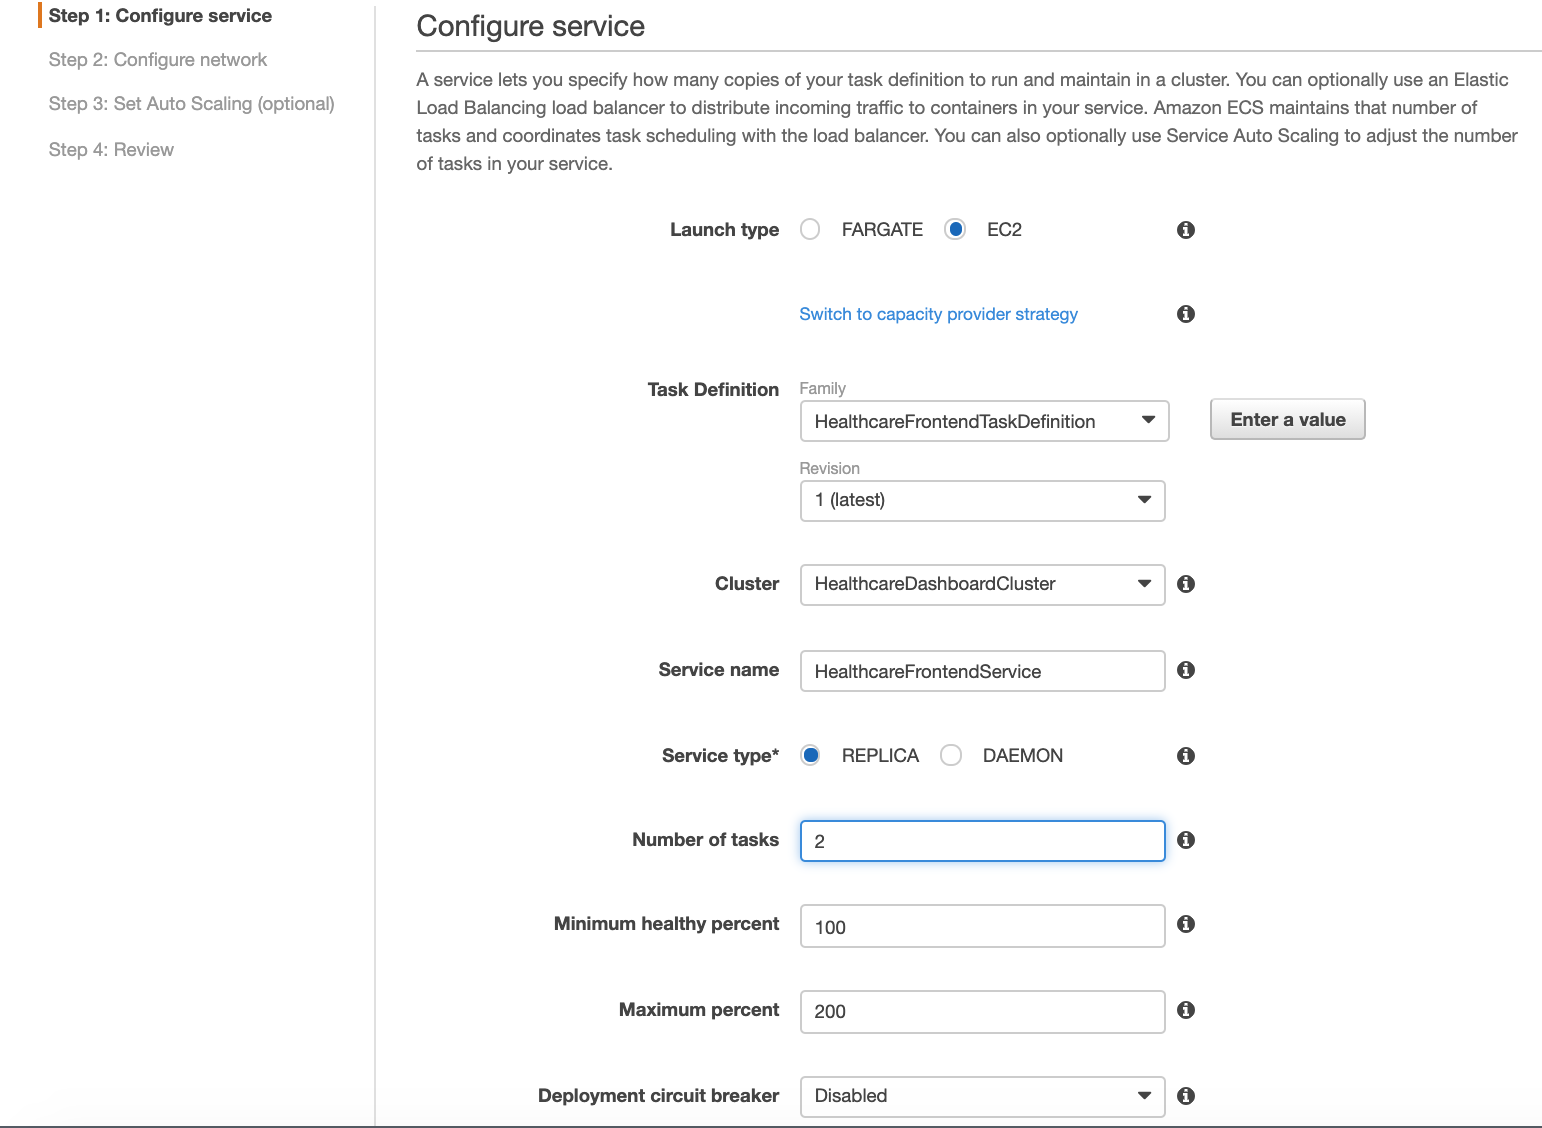



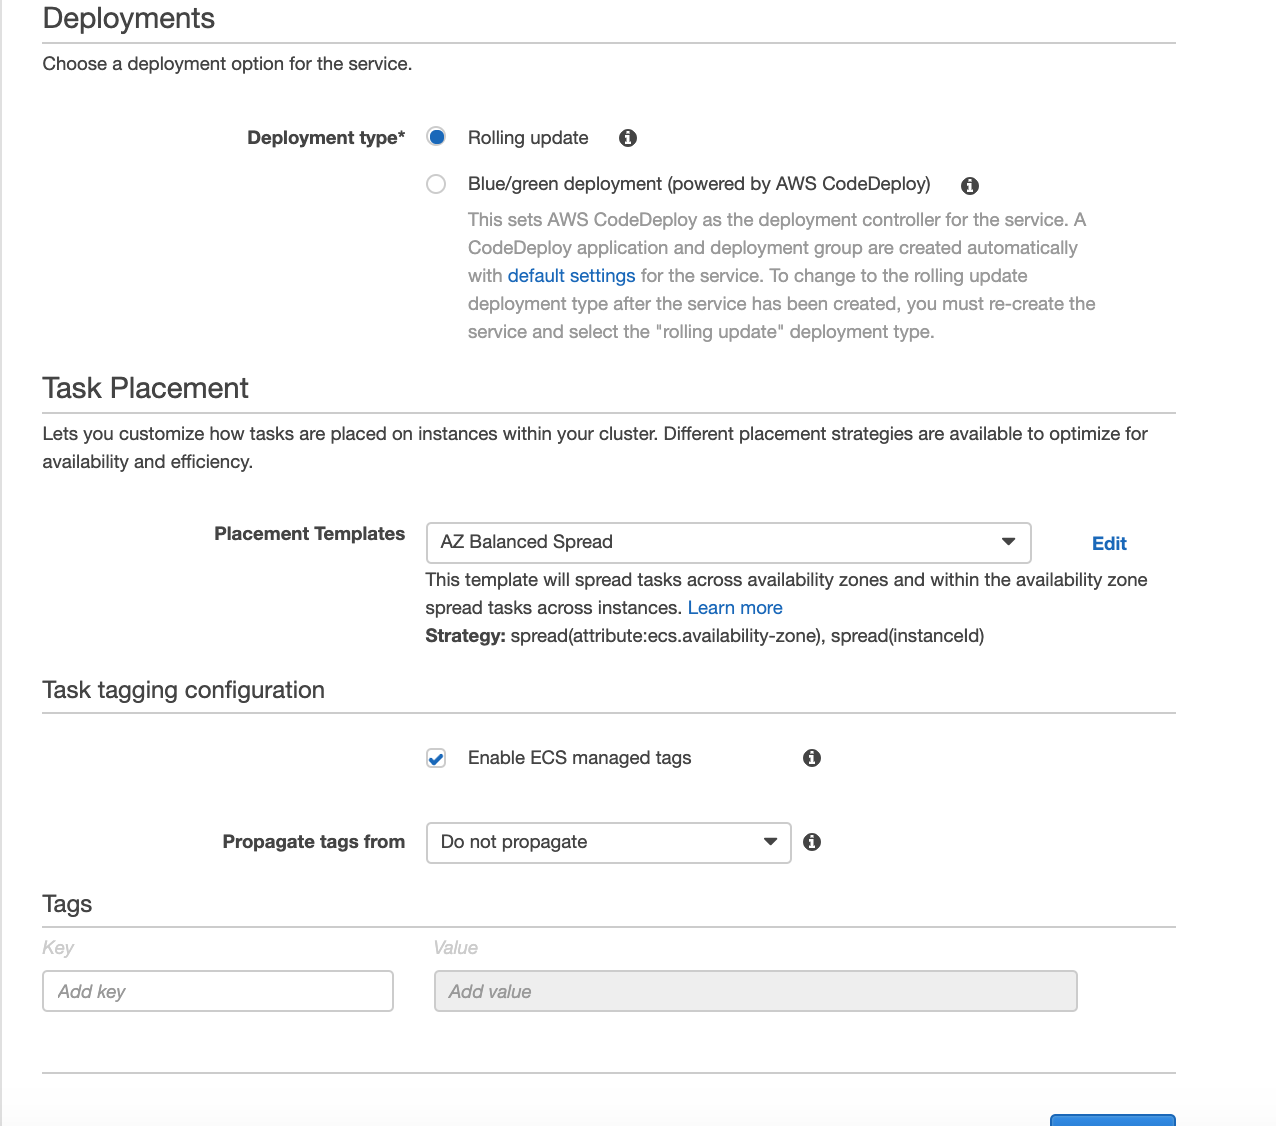



3. In the next screen, we are going to configure load balancer since we have setup 2 tasks as desired count. Select Application Load Balancer as the type and click on Create new load balancer button. Once clicked, select application load balance and click on next button.

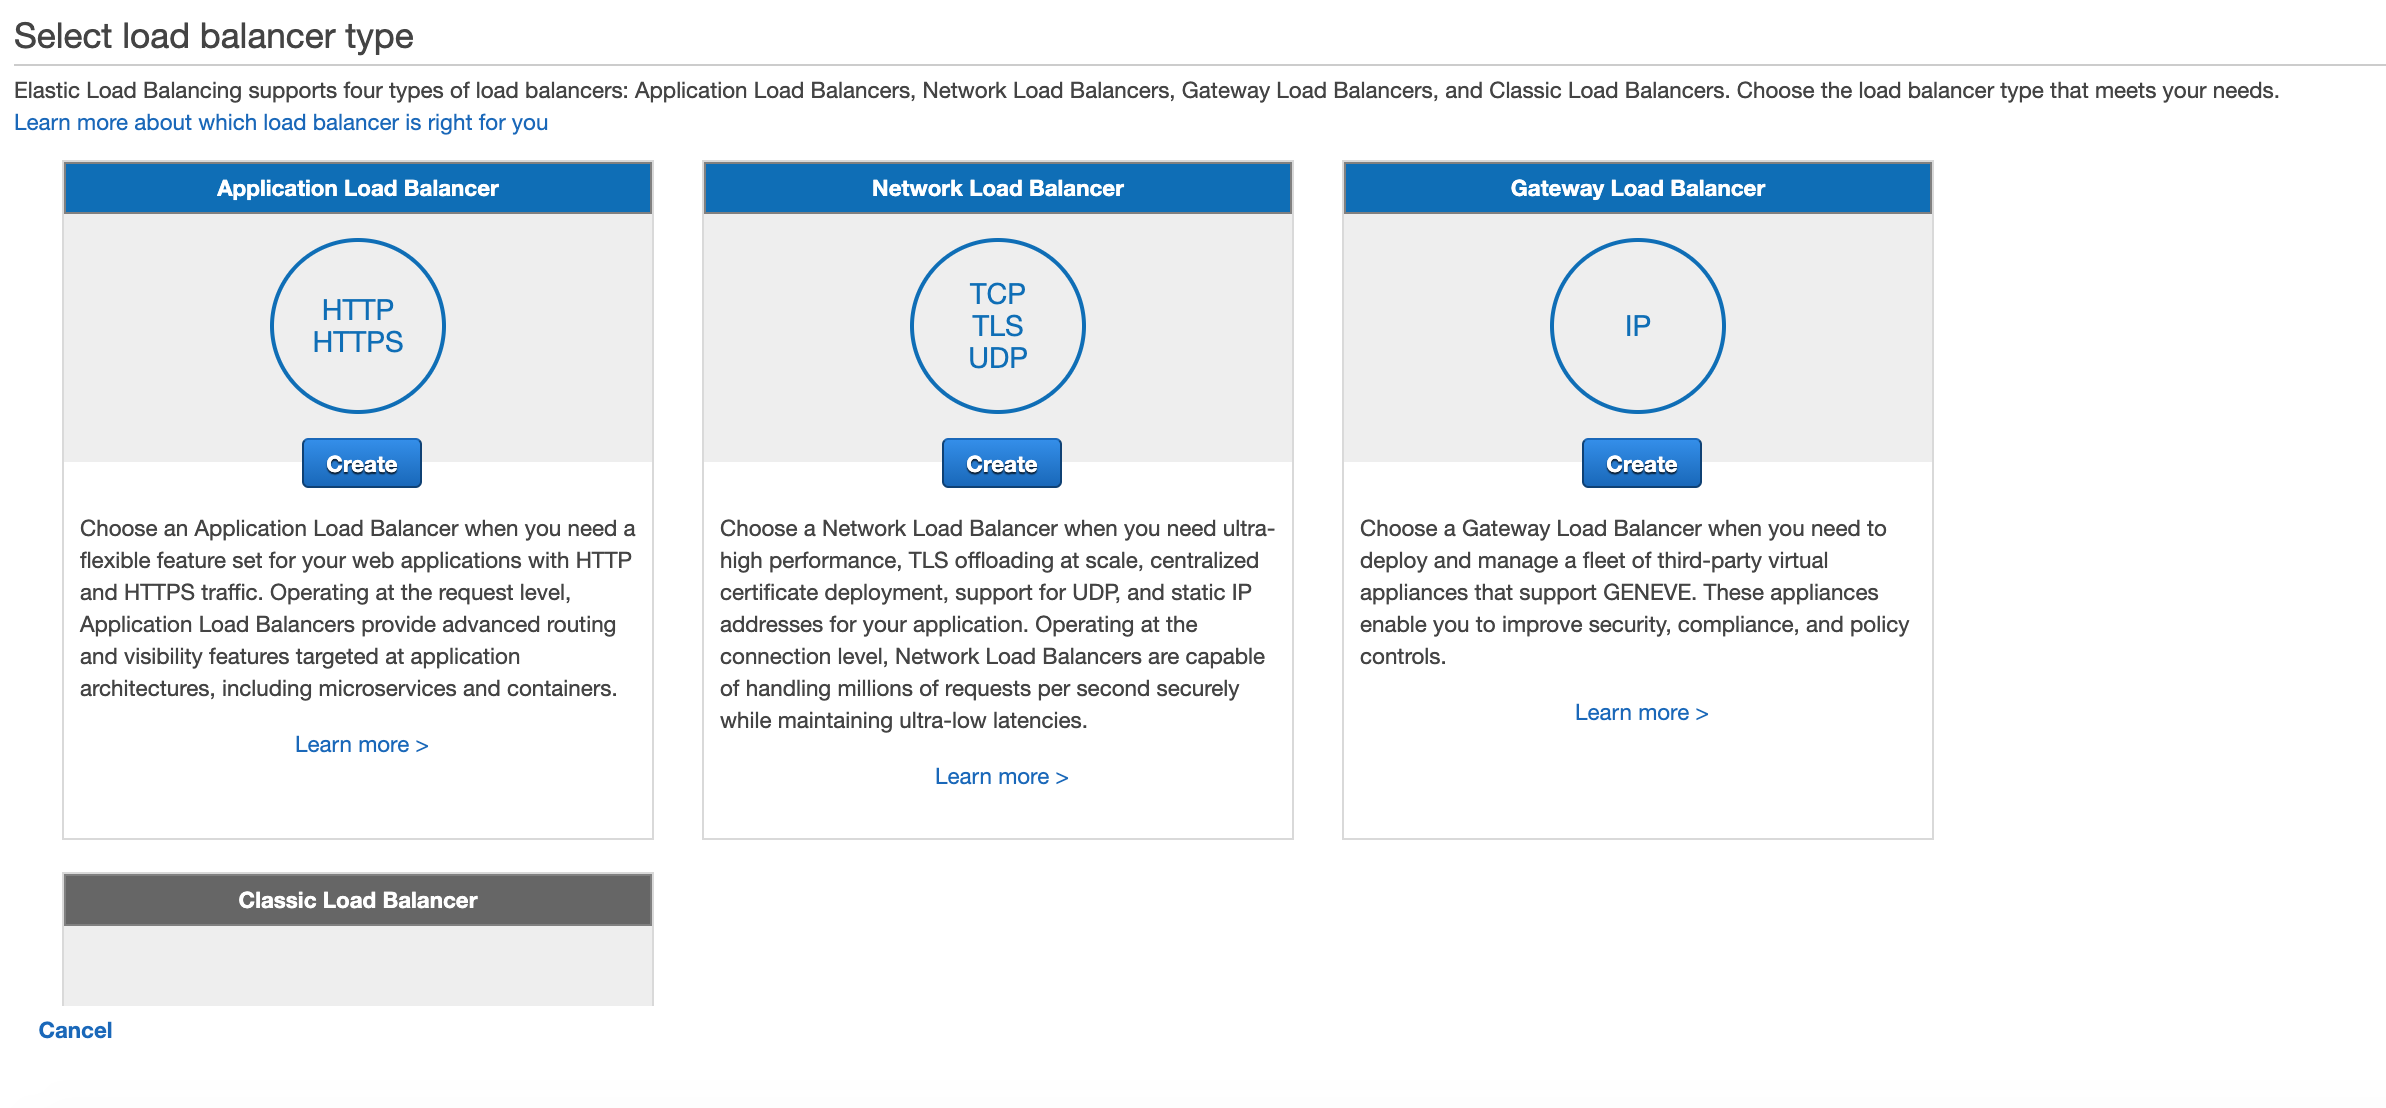



4. In the next screen, enter the name as `HealthcareECSALB`, select internet facing, and leave the listener with http & port 80. In availabulity zone, select all the availability zone. Click on Next button.

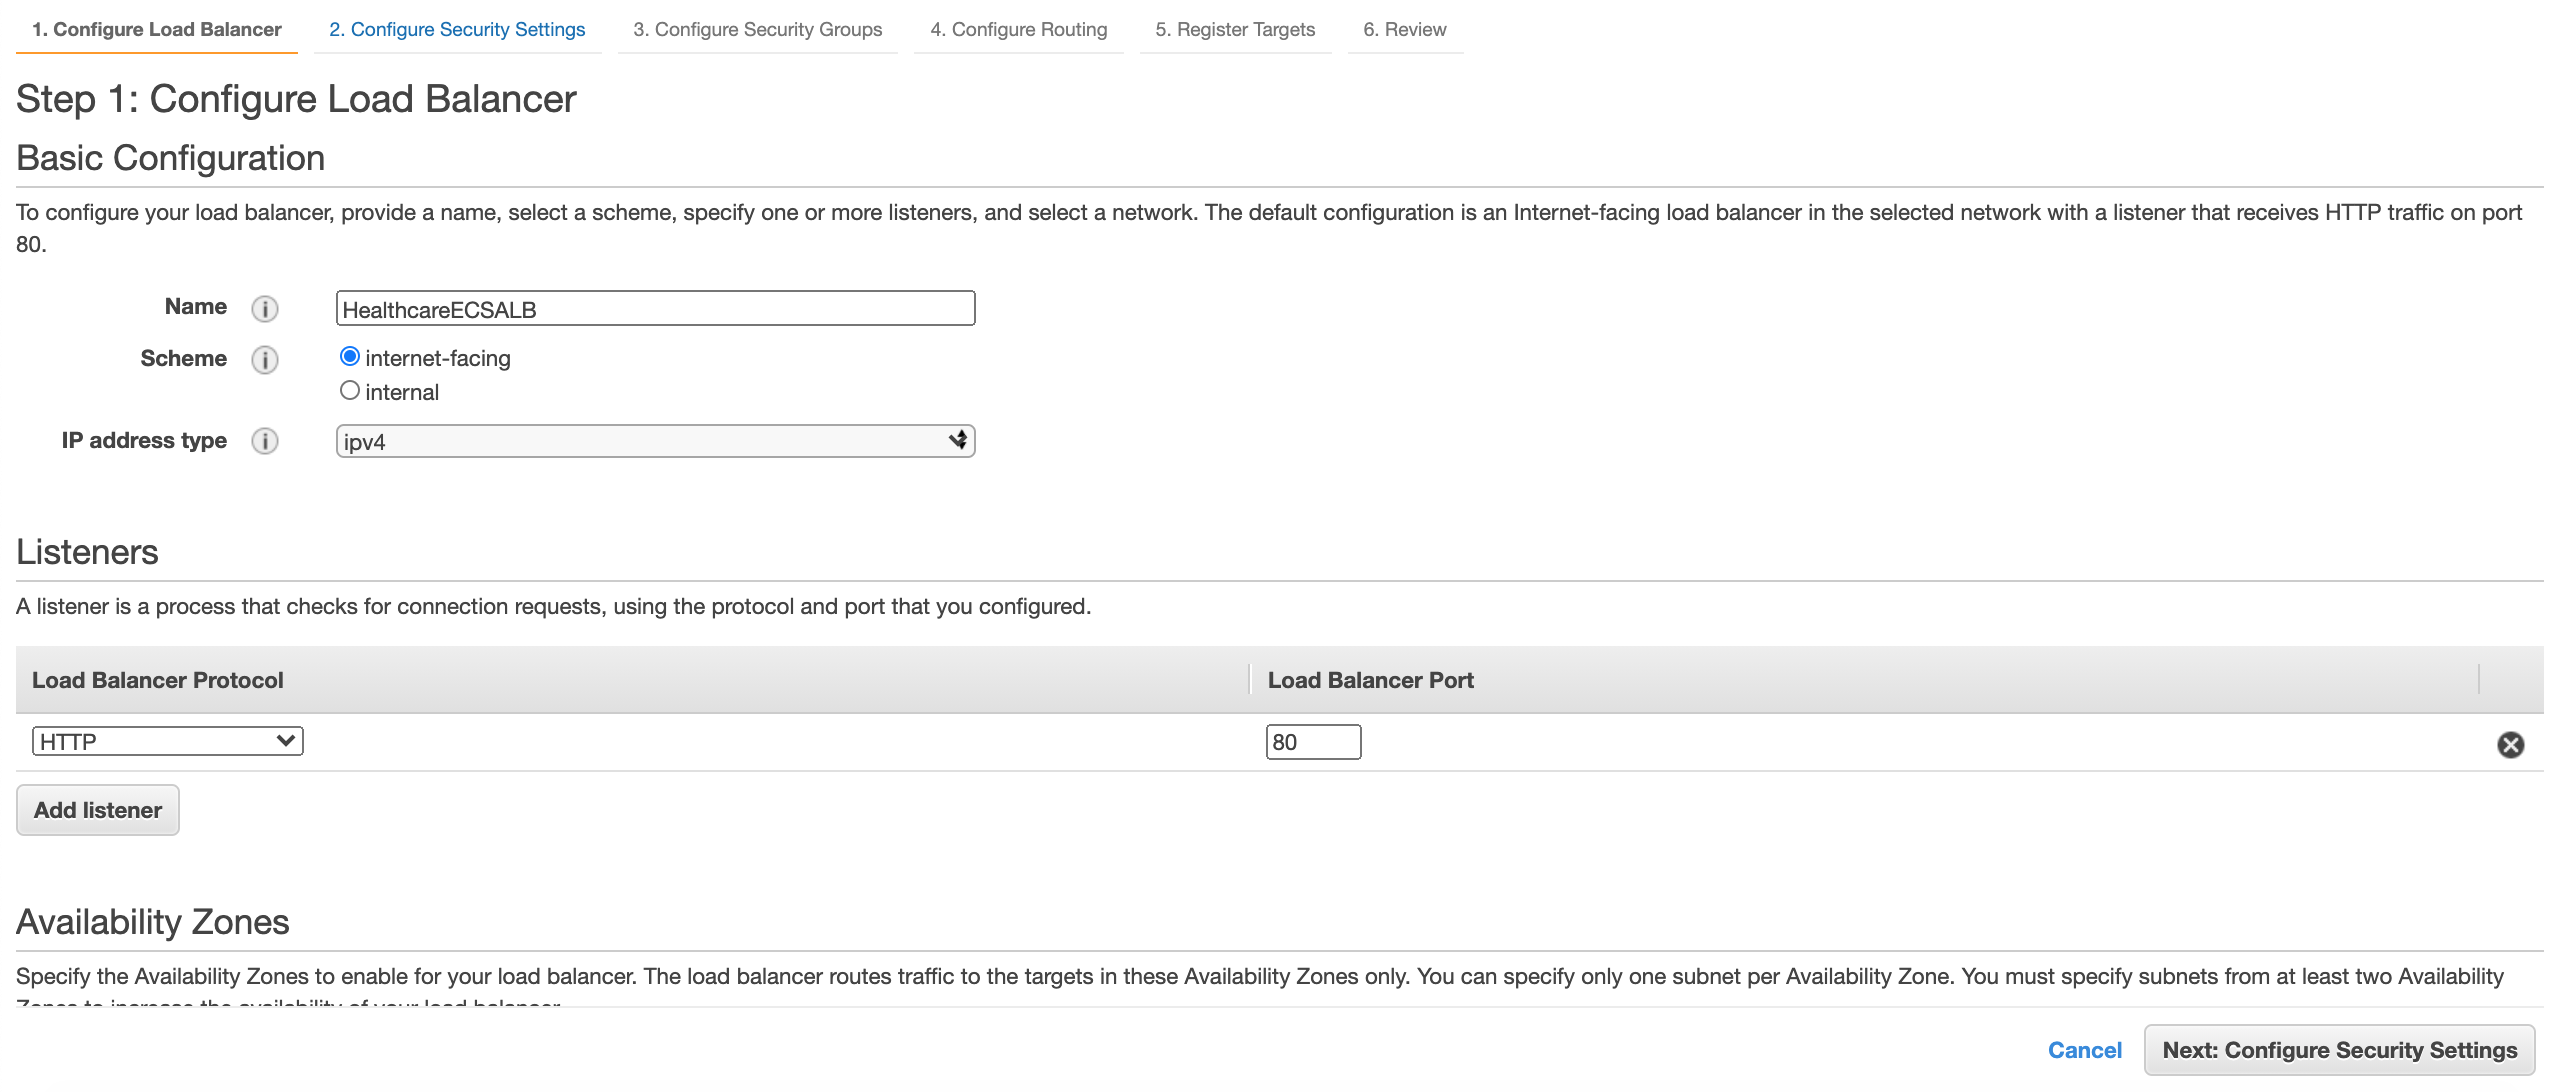



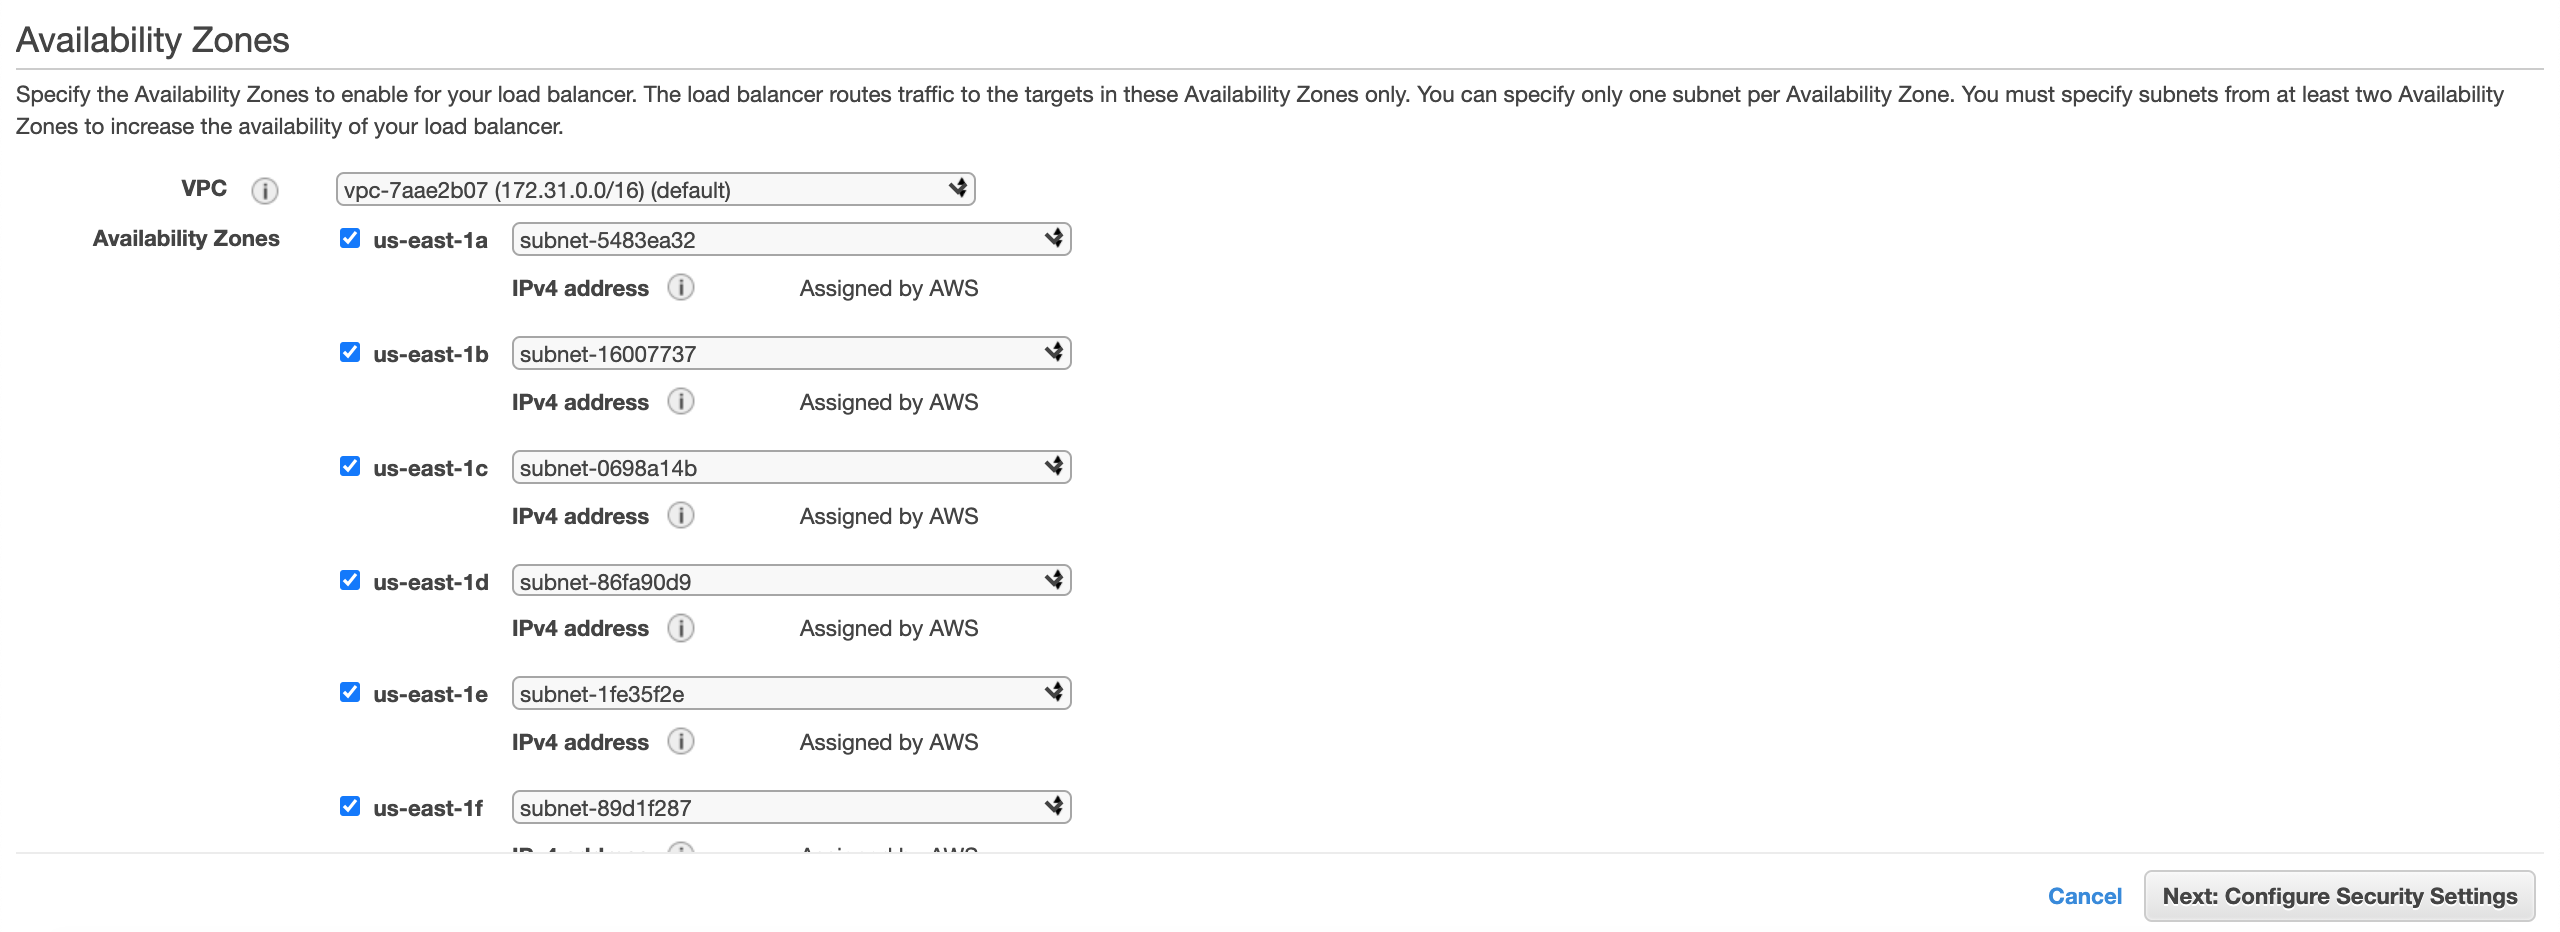



5. In the next screen, we are going to create a new security group. Enter the name as `HealthcareECSALBSG` and allow only http with port from anywhere in inbound rule.

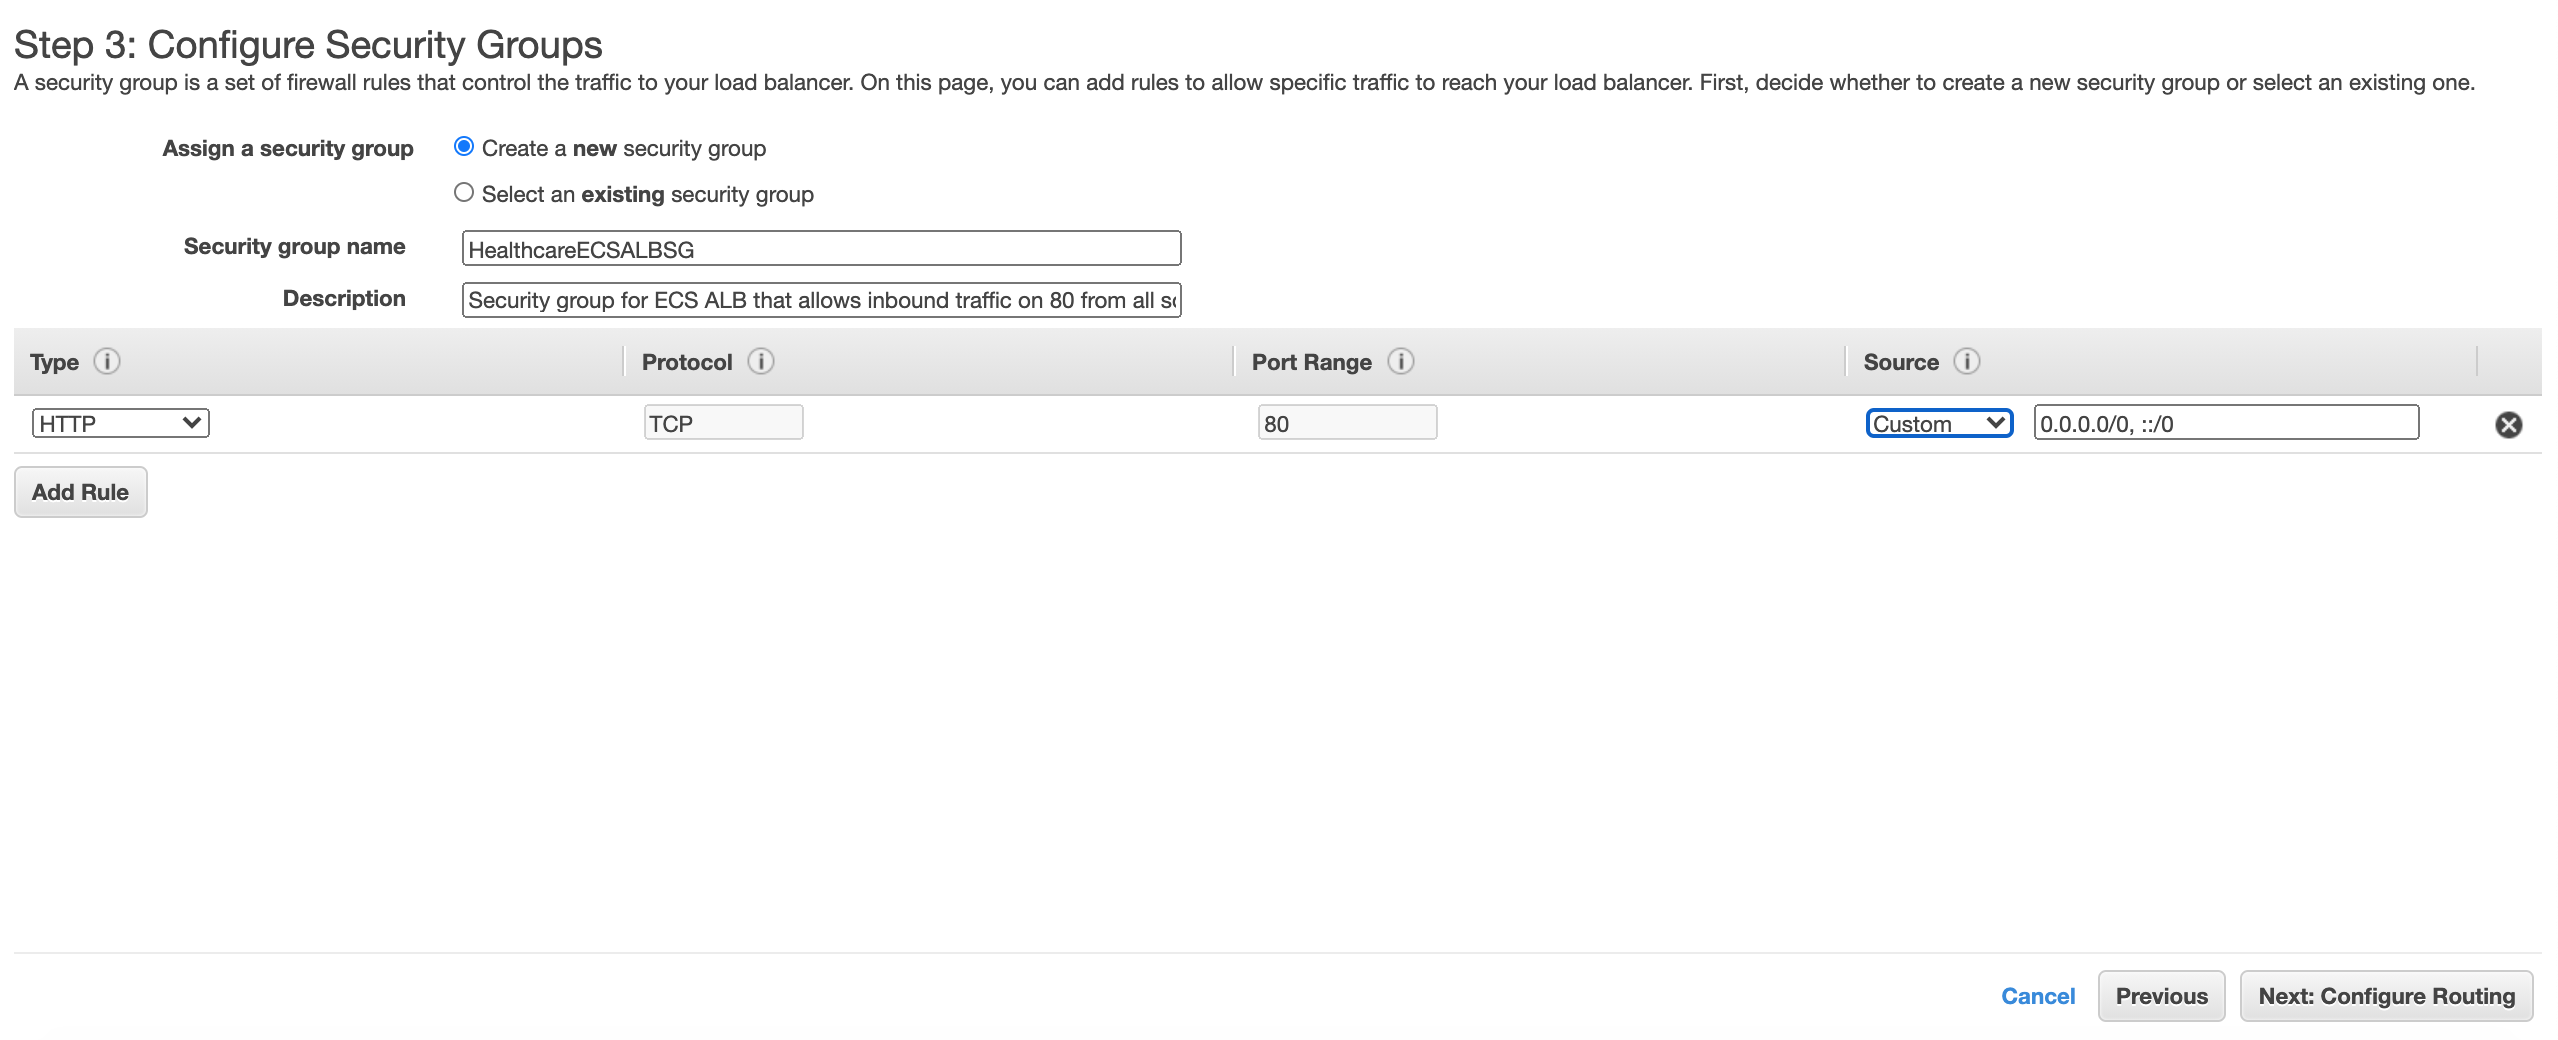



6. In the next screen, we are going to create a new target group. Enter the name as `HealthcareECSALBTG` and enter the other details as in the below screen. Click on next button when done.

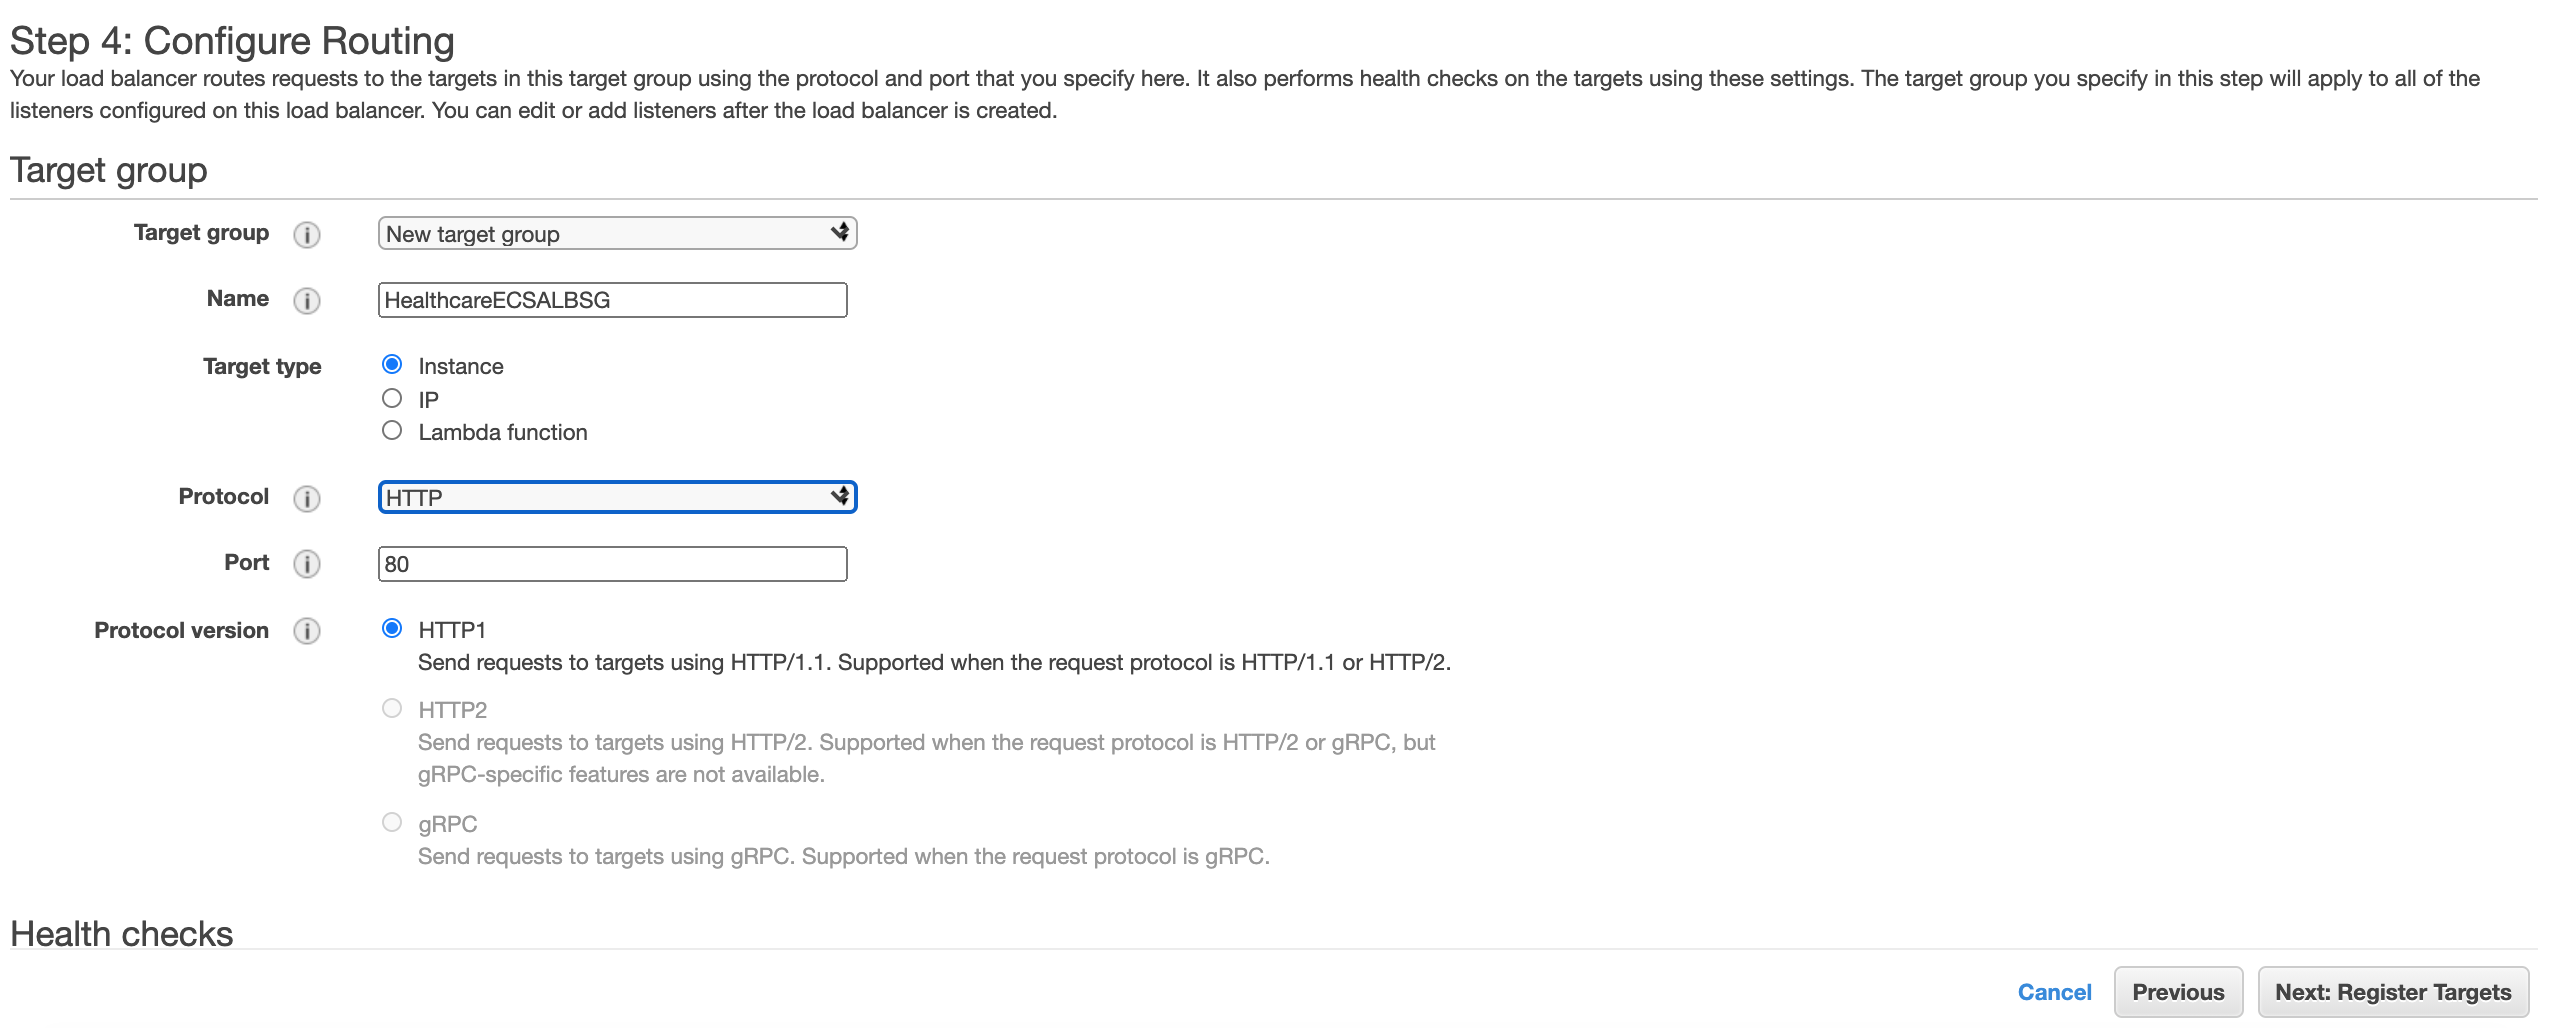



7. In the next screen, we dont need to register any targets since ECS Service will register our containers with ALB/Target Group automatically once it creates the containers with dynamic port. Click on Next button with out registering any targets.

8. In the next screen, please review the details once and click on create button. It takes a while to provision ALB, hence be patient.

9. Once the ALB is active, we can go back to ECS service screen and select the cretaed the ALB in the drop down as shown below.

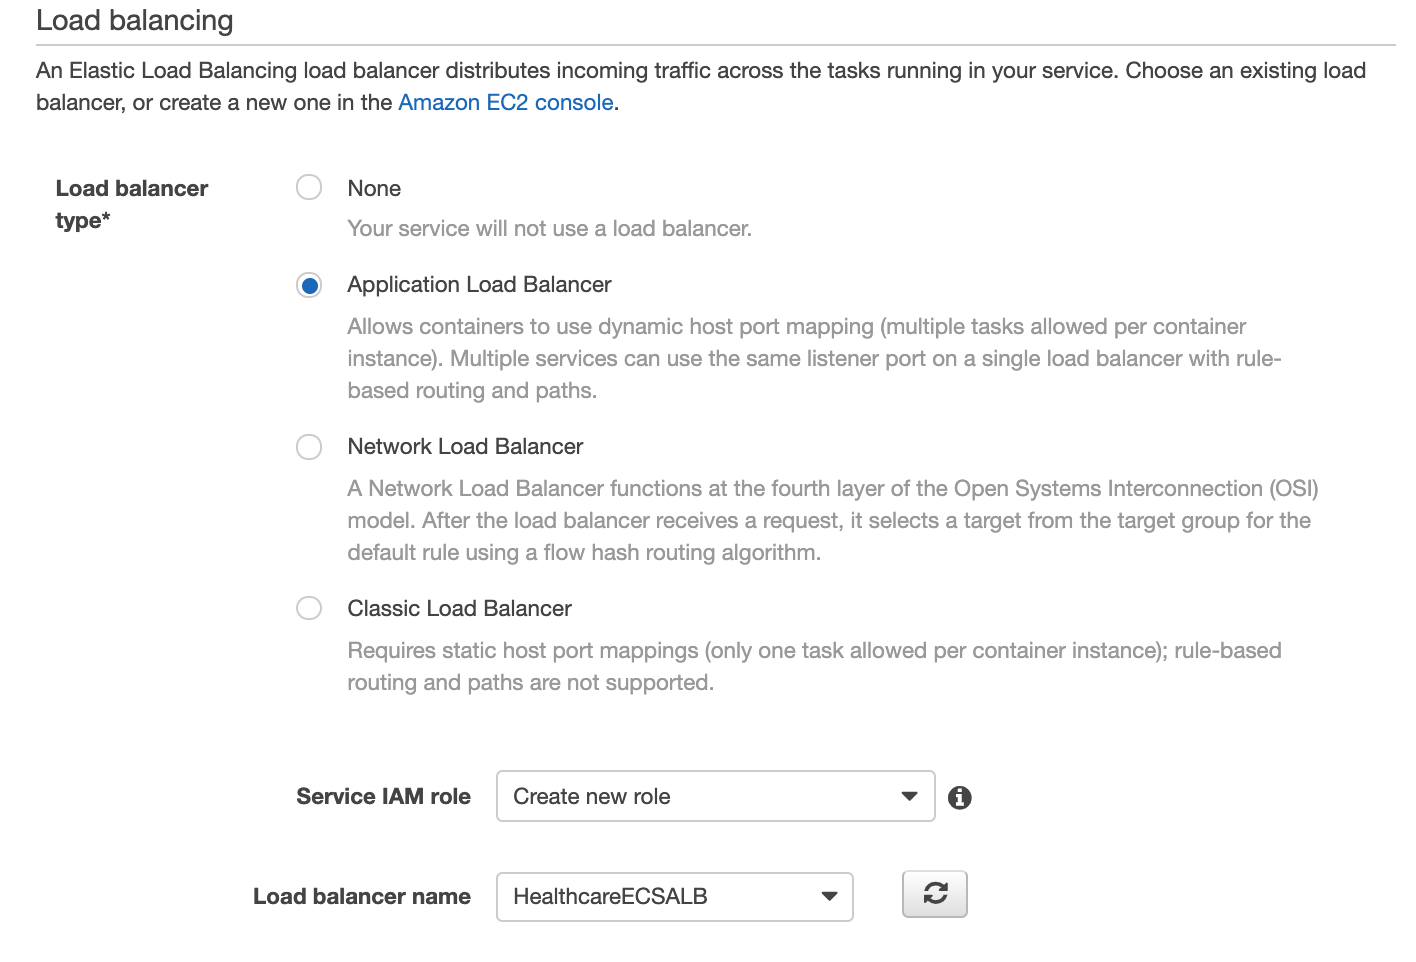



10. In the `Container to load balance` section, click on add to load balancer button and enter the details as shown below. In the target group name, please select the target group that we select in the previous step. Name should be `HealthcareECSALBTG`. Click on Next Step once done.

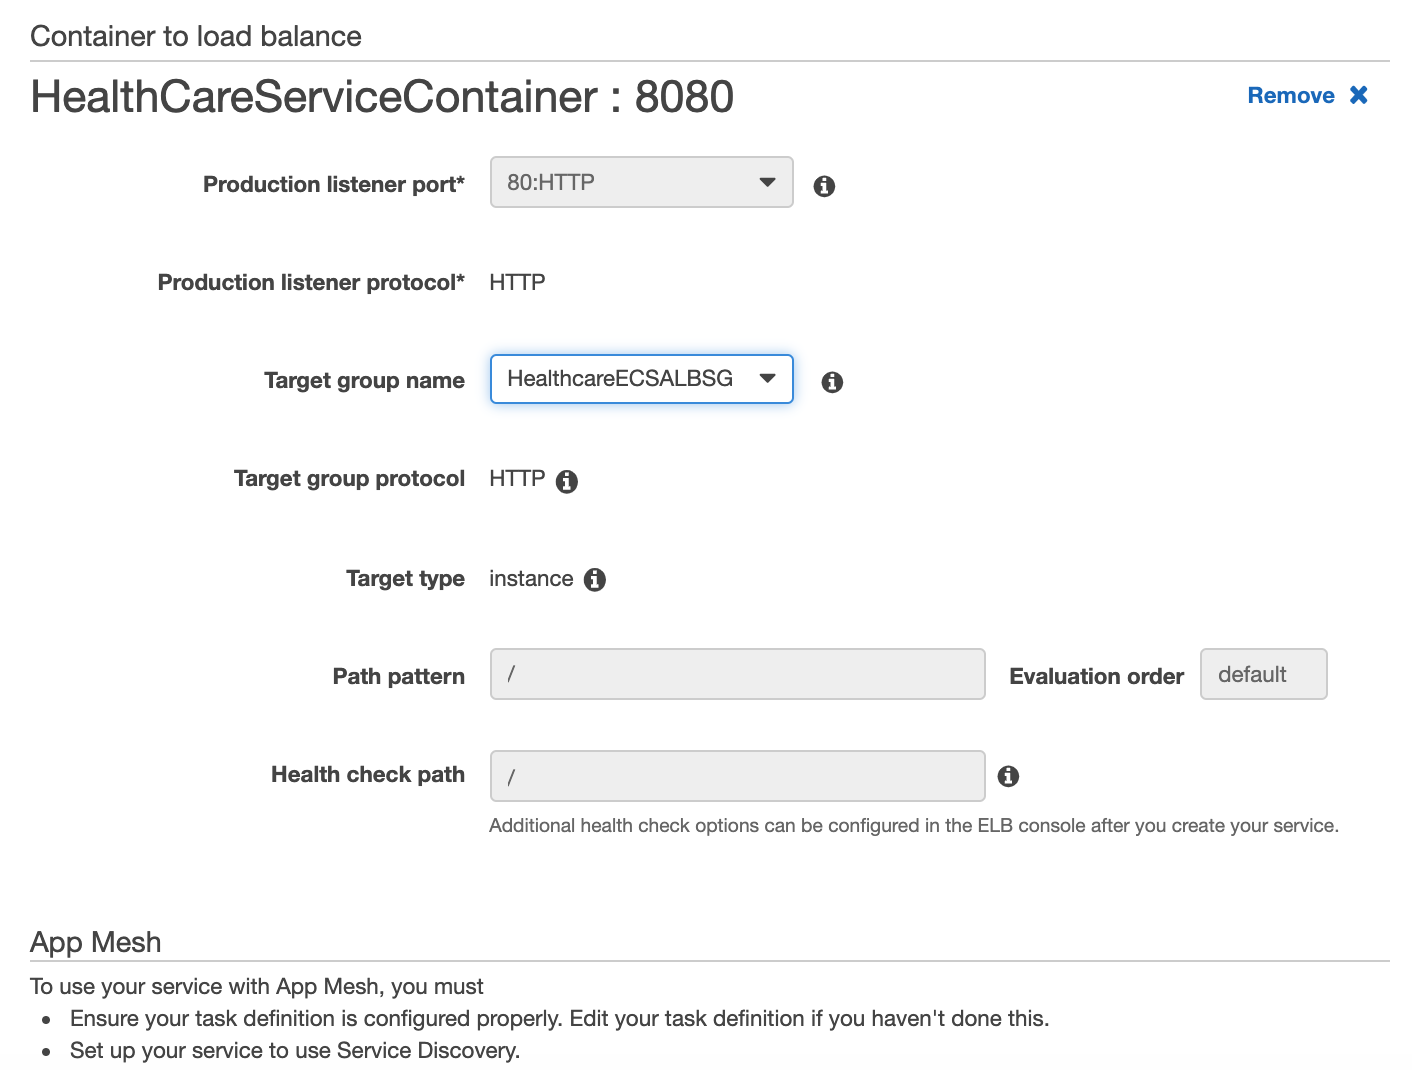



11. In the next step, select `Do not adjust the service's desired count` since we are not allowed to select auto scaling in AWS Educate account. If you use your personal account, you can select auto scaling using which your containers/tasks will automatically scale up and down based on certain configuration such CPU or Memory consumption. Click on Next Step.

12. Review all the details and click on Create Service. Once the Service is created, you will be able to see Tasks automatically starting in the 2 EC2 instances that we created in this Cluster.

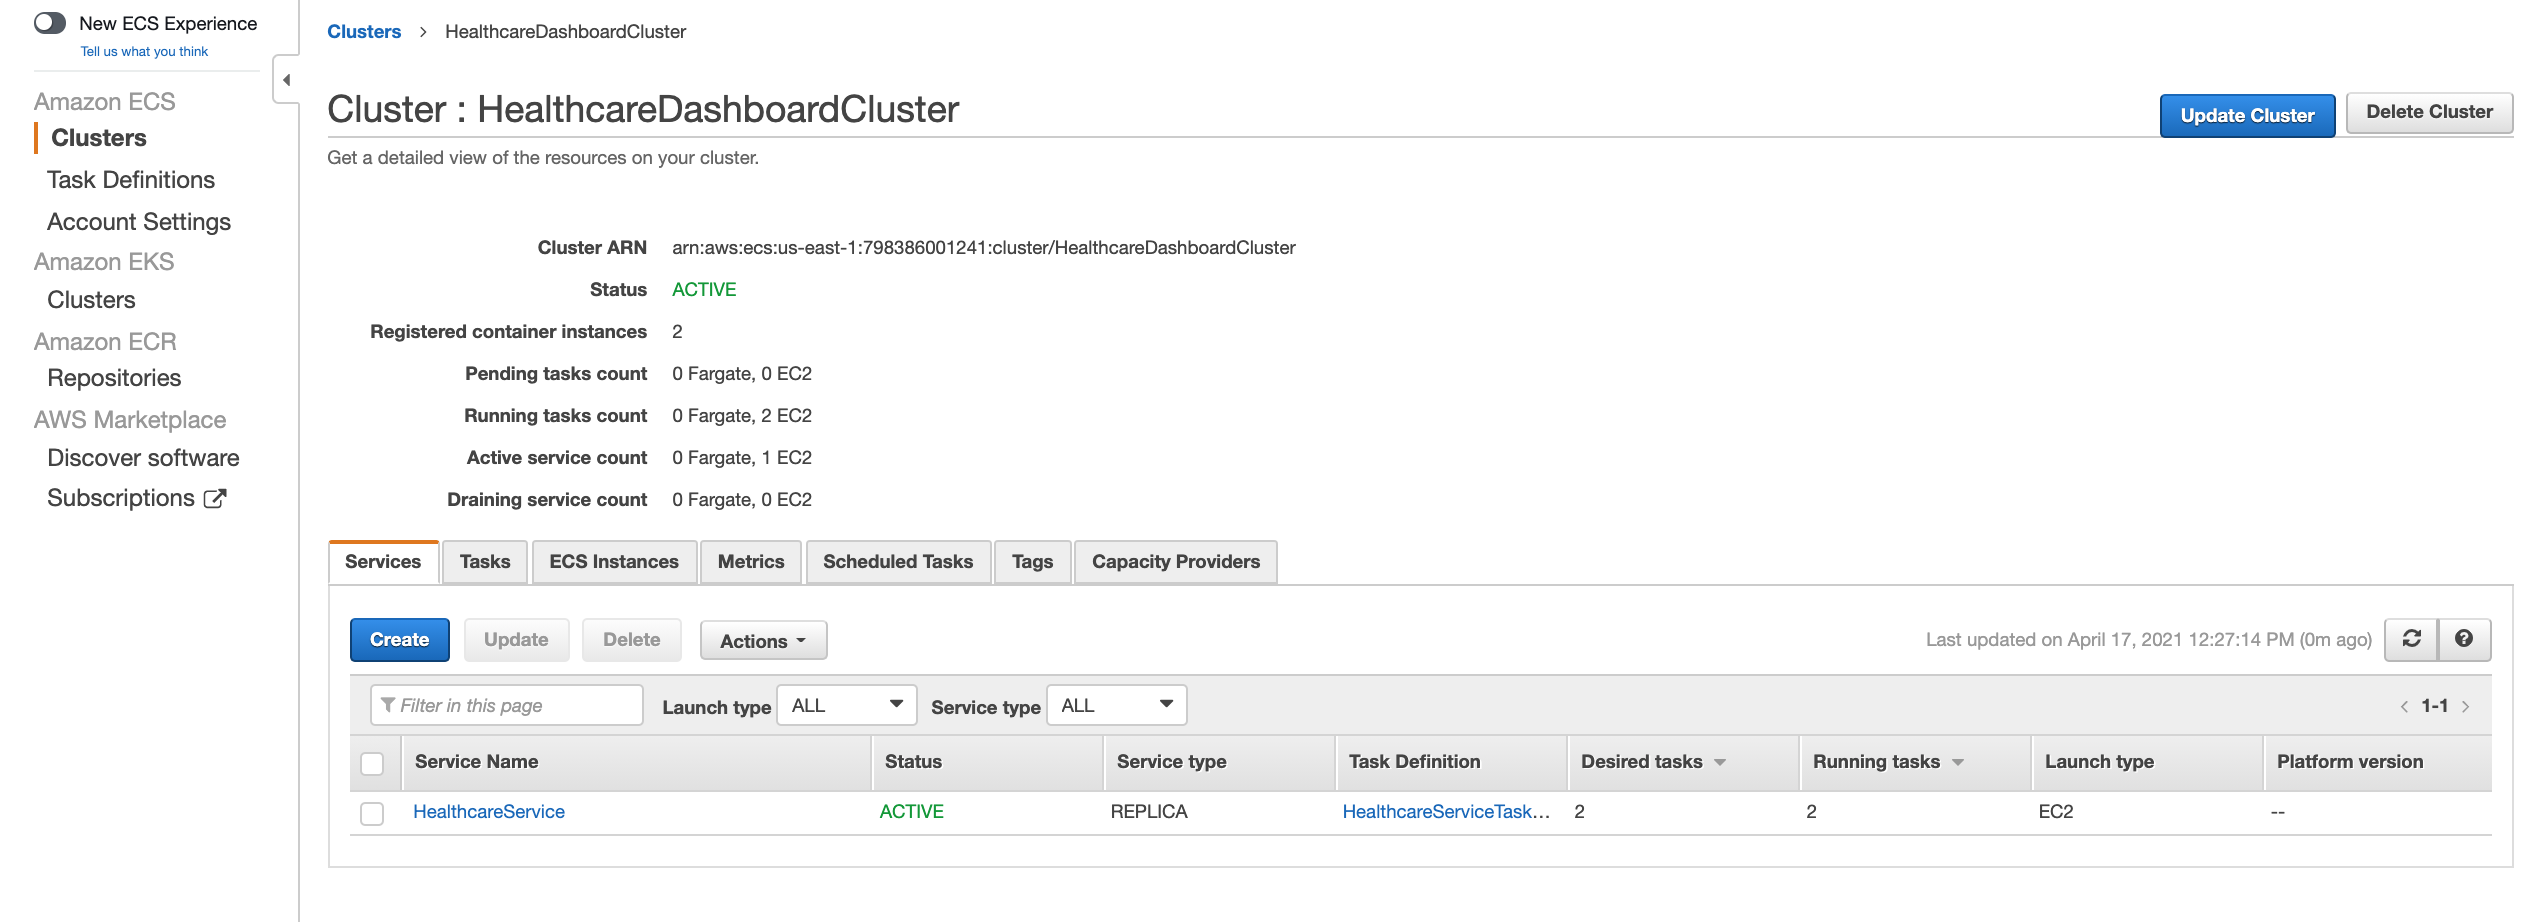


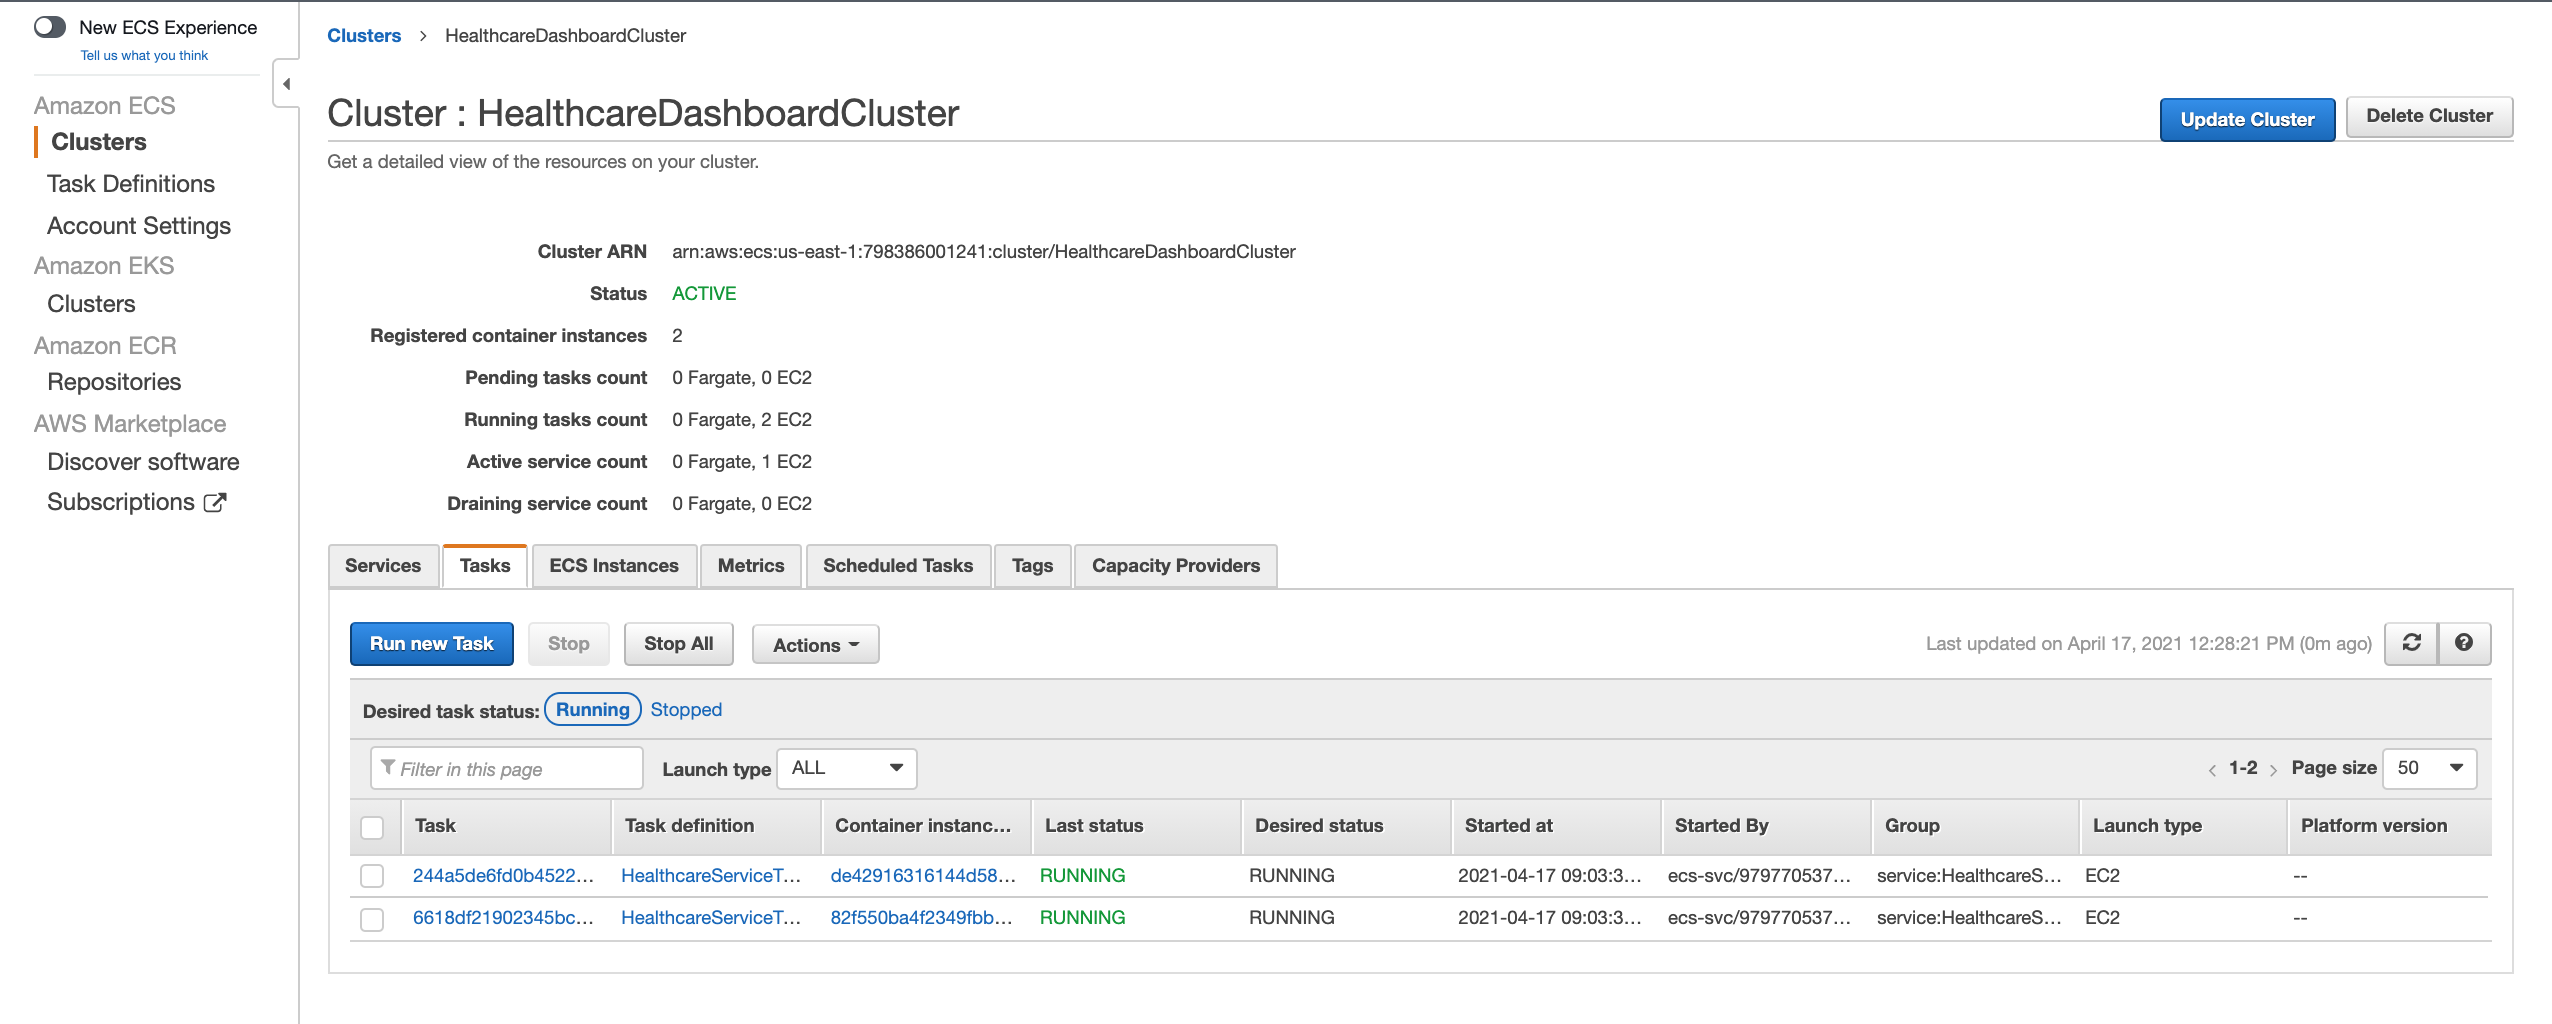



13. We need to do one more modification before we can test the application. Since we attached an old Security Group (HealthCareDashboardEC2SG) to the EC2 instances, we need to go there and modify the inbound rules to allow traffic from ALB to EC2 instances on any port since the ports are dynamic now. Let's go the Security Group of EC2 instances and modify the inbound rules as per the below screen.

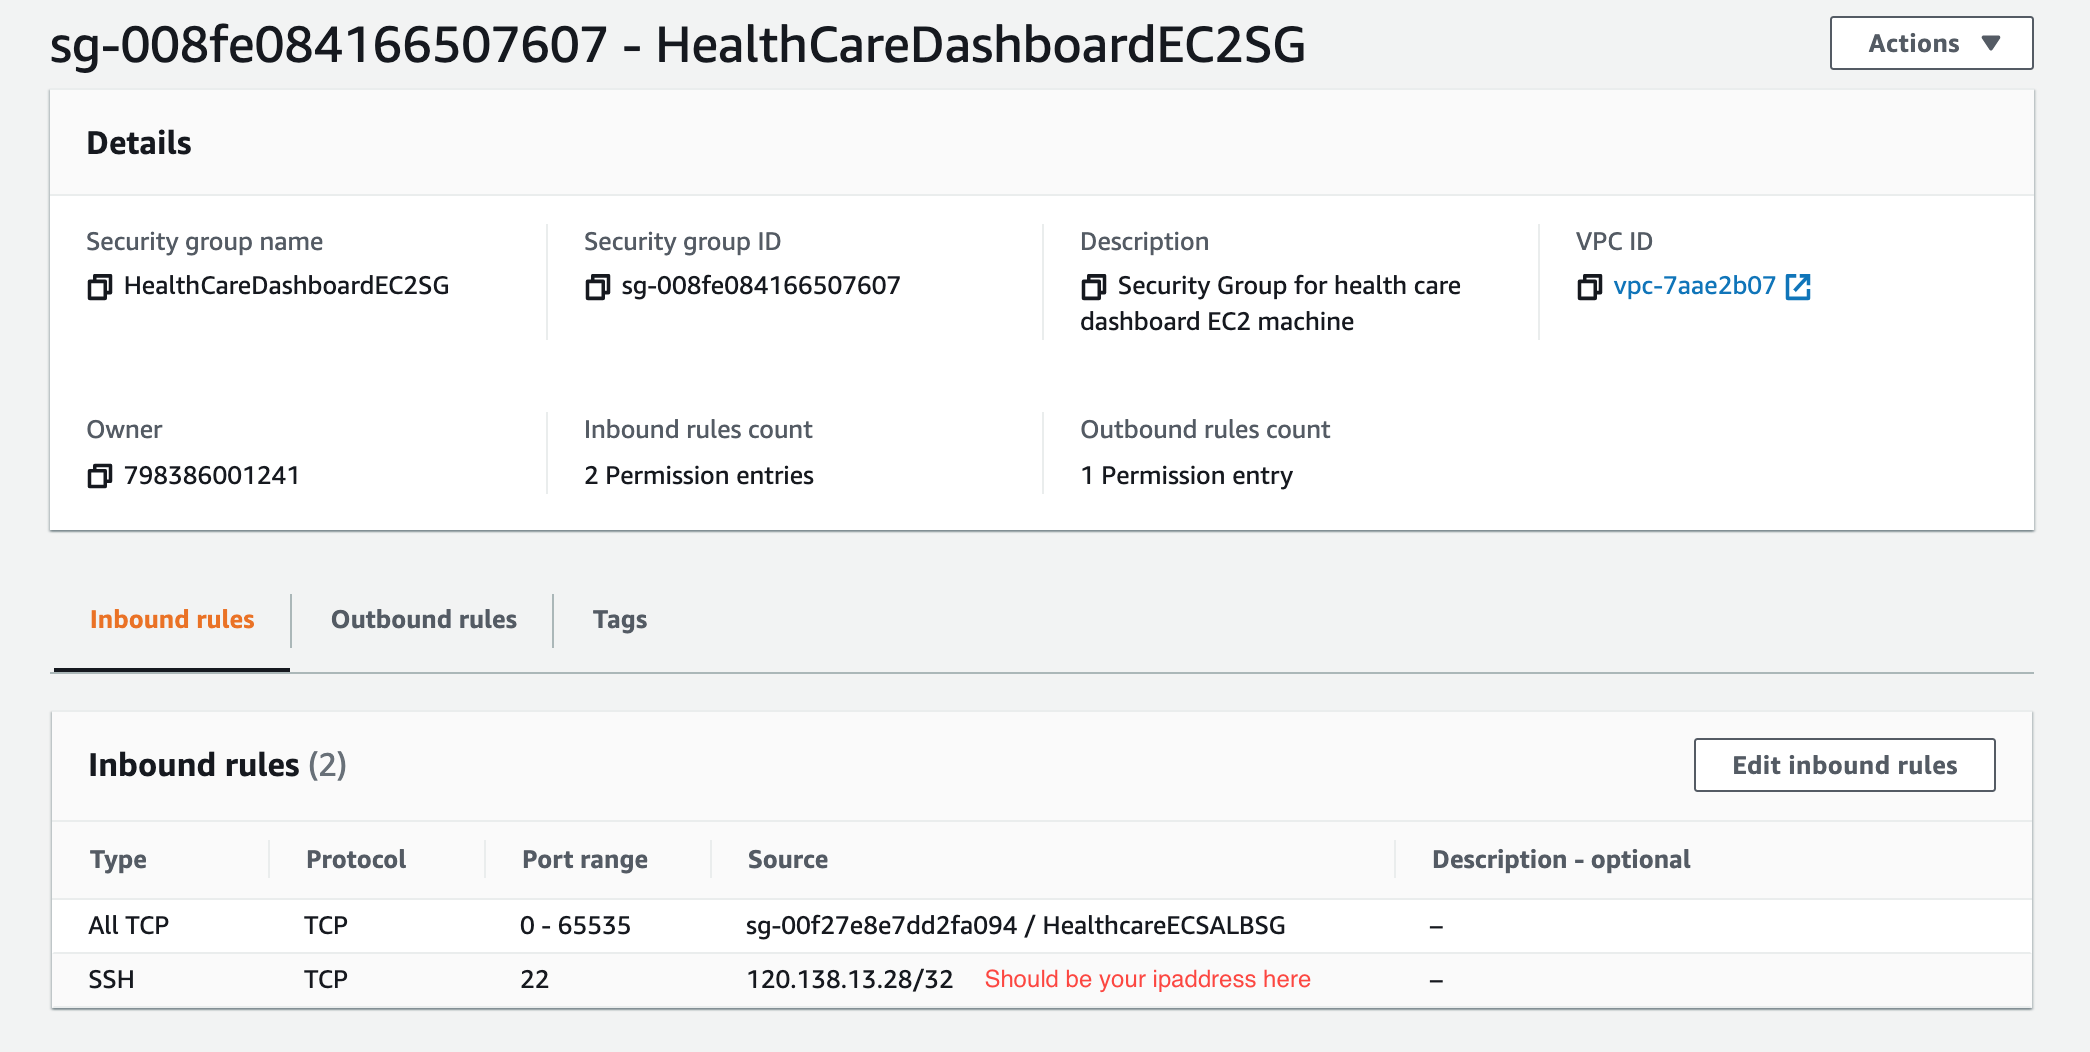

14. Now, we should be able to test our API using the public DNS of our Application Load Balancer (ALB). Replace the tokens below and try it out in a browser window.

<code> http://(ALBPublicDNS)/api/raw-data?deviceid=(DeviceId)&startdate=(StartDate)&enddate=(EndDate) </code>

# <font color='blue'> Task Definition - Frontend </font>

In this step, we are going to create task definition for our frontend application. Before we create the task definition for our frontend, we need to modify the source code of our frontend and change the URL to public DNS of the new ALB we created.

1. Let's go ahead, SSH into one of the EC2 instances and copy the frontend app source code from S3 bucket into EC2 machine. And then we will extract the zip file for Fronend application. Enter the below commands while replacing your S3 bucket name. If this command does not work, then add S3 full access managed policy to your ec2 instance IAM role that we created earlier. This is needed in order to access S3 bucket from within the EC2 instance. Or you can use one of the EC2 instances that we launched as part of the previous module so that you don't have modify the EC2 Instance Role.

<code>aws s3 cp (S3BucketName) FrontEndApp.zip 
 unzip FrontEndApp.zip </code>

2. After extracting the source code from S3, inside src->app>service folder of the FrontEndApp, we need to modify the file healthcare-data.service.ts file. Please copy the public DNS of the ALB that we created in one of the previous steps and replace it in the healthCareServiceURL variable. This is needed in order to access the Backend Service that we created earlier through the ALB. In real world, we will not be doing this and the below 5 steps because we would have a Domain name for our ALB and we would use it as a host name in our URL.

<code>private healthcareServiceURL = 'http://(ALBPublicDNS)/api/raw-data?';</code>

3. Now navigate back to FrontEndApp folder. Enter the below command. Replace the (awsaccountid) with your own aws account id.

docker build . -t (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/frontend:latest

3. With the above code, We are issuing a command to Docker daemon to build a container image with a tag name that is specified after -t. This is needed in order to push this image to the repository that we created above. If the command is successful, we should be able to see the container image created using the below command.

<code> docker image ls </code>

4. We built the docker image for frontend application in the previous step. Let's go ahead and push this docker image to ECR so that we can pull it from EC2 machine. Use the below command to login with your Docker client. Replace the (awsaccountid) with your own aws account id. After you run the commands, you can go to ECR and check the repos. You should have one container image in the healthcare/frontend repo with latest as the tag.
<code>
aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin (awsaccountid).dkr.ecr.us-east-1.amazonaws.com

docker push (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/frontend:latest </code>

5. Now, let's go ahead and create task definition for our frontend application quickly using the below screenshots. Let's go to ECS -> Task Definitions and click on create task definition and follow the below screenshots.

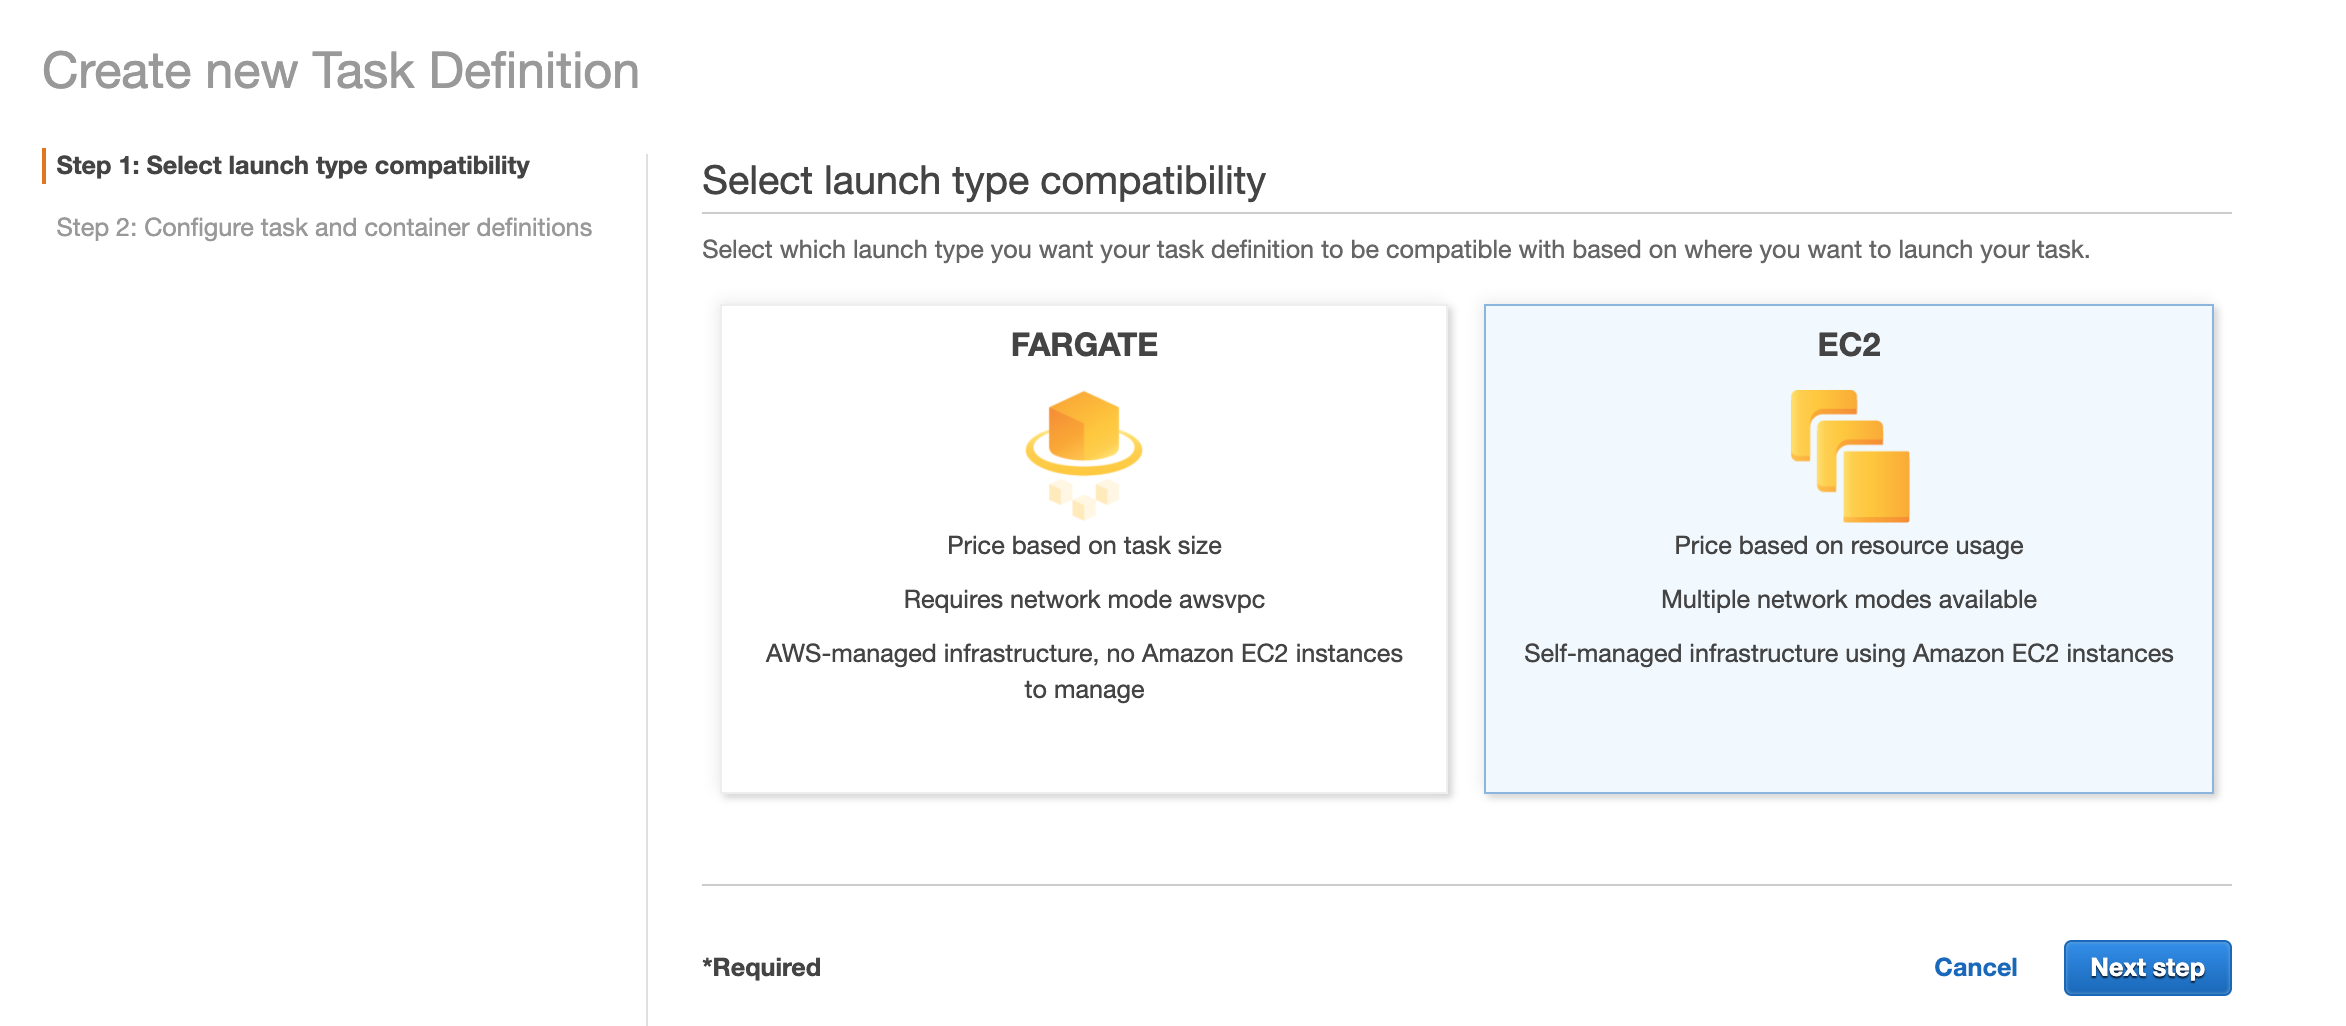


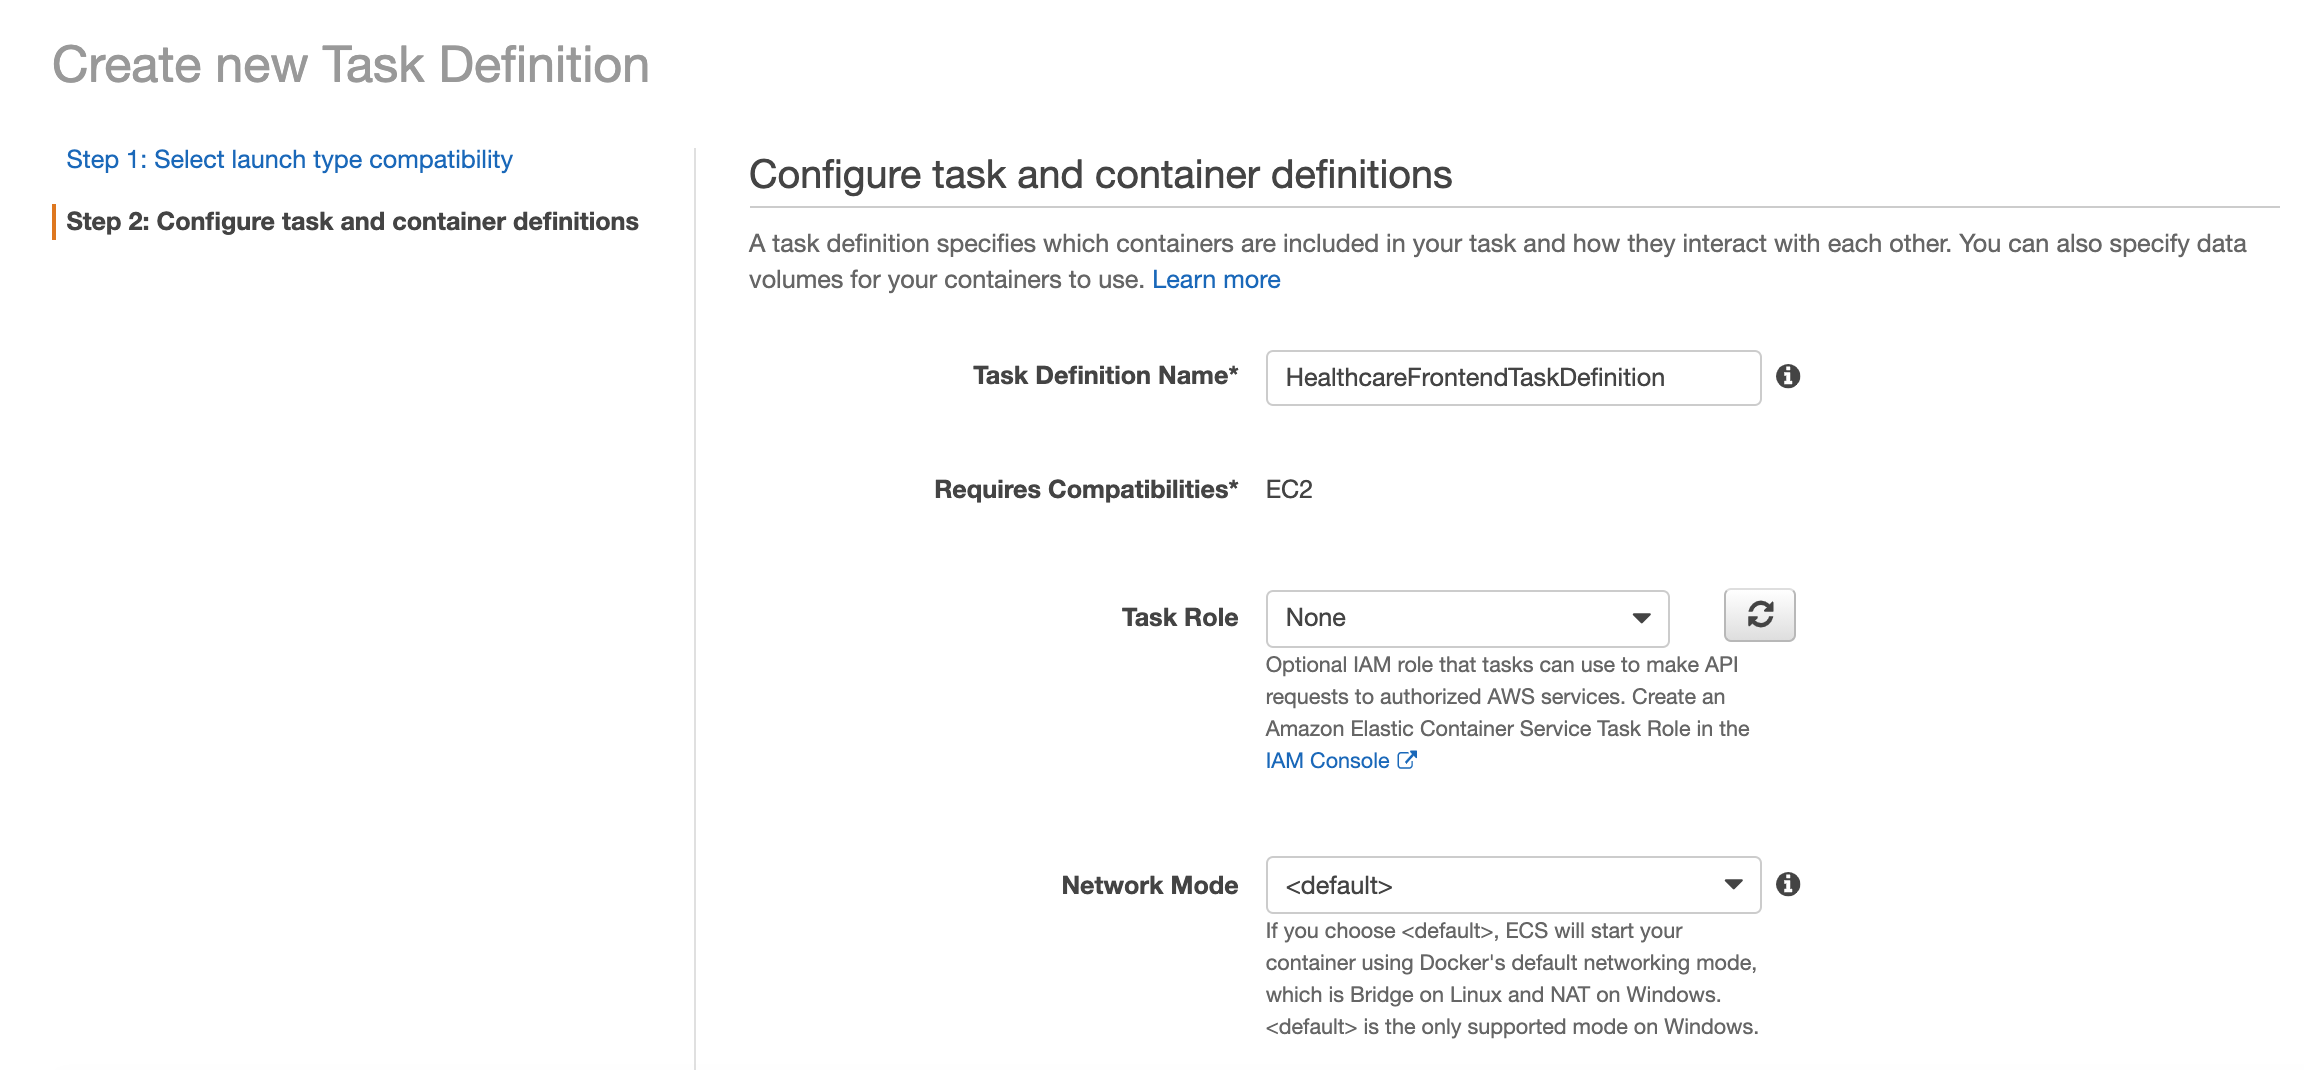


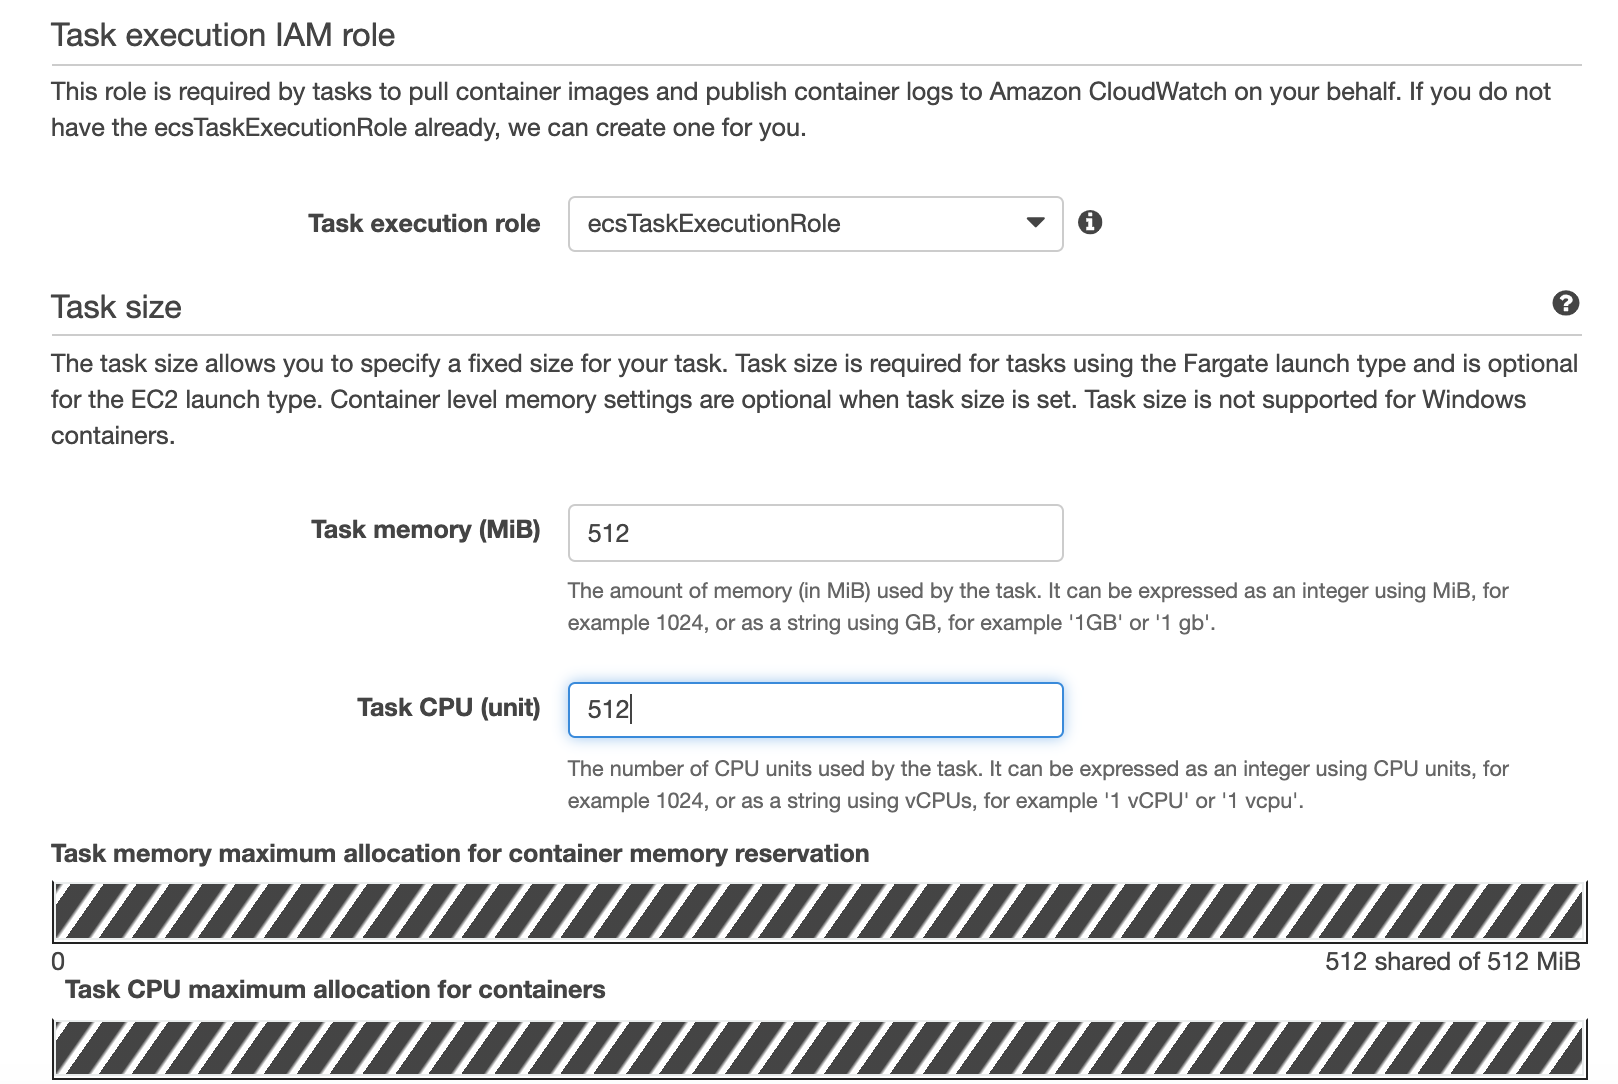


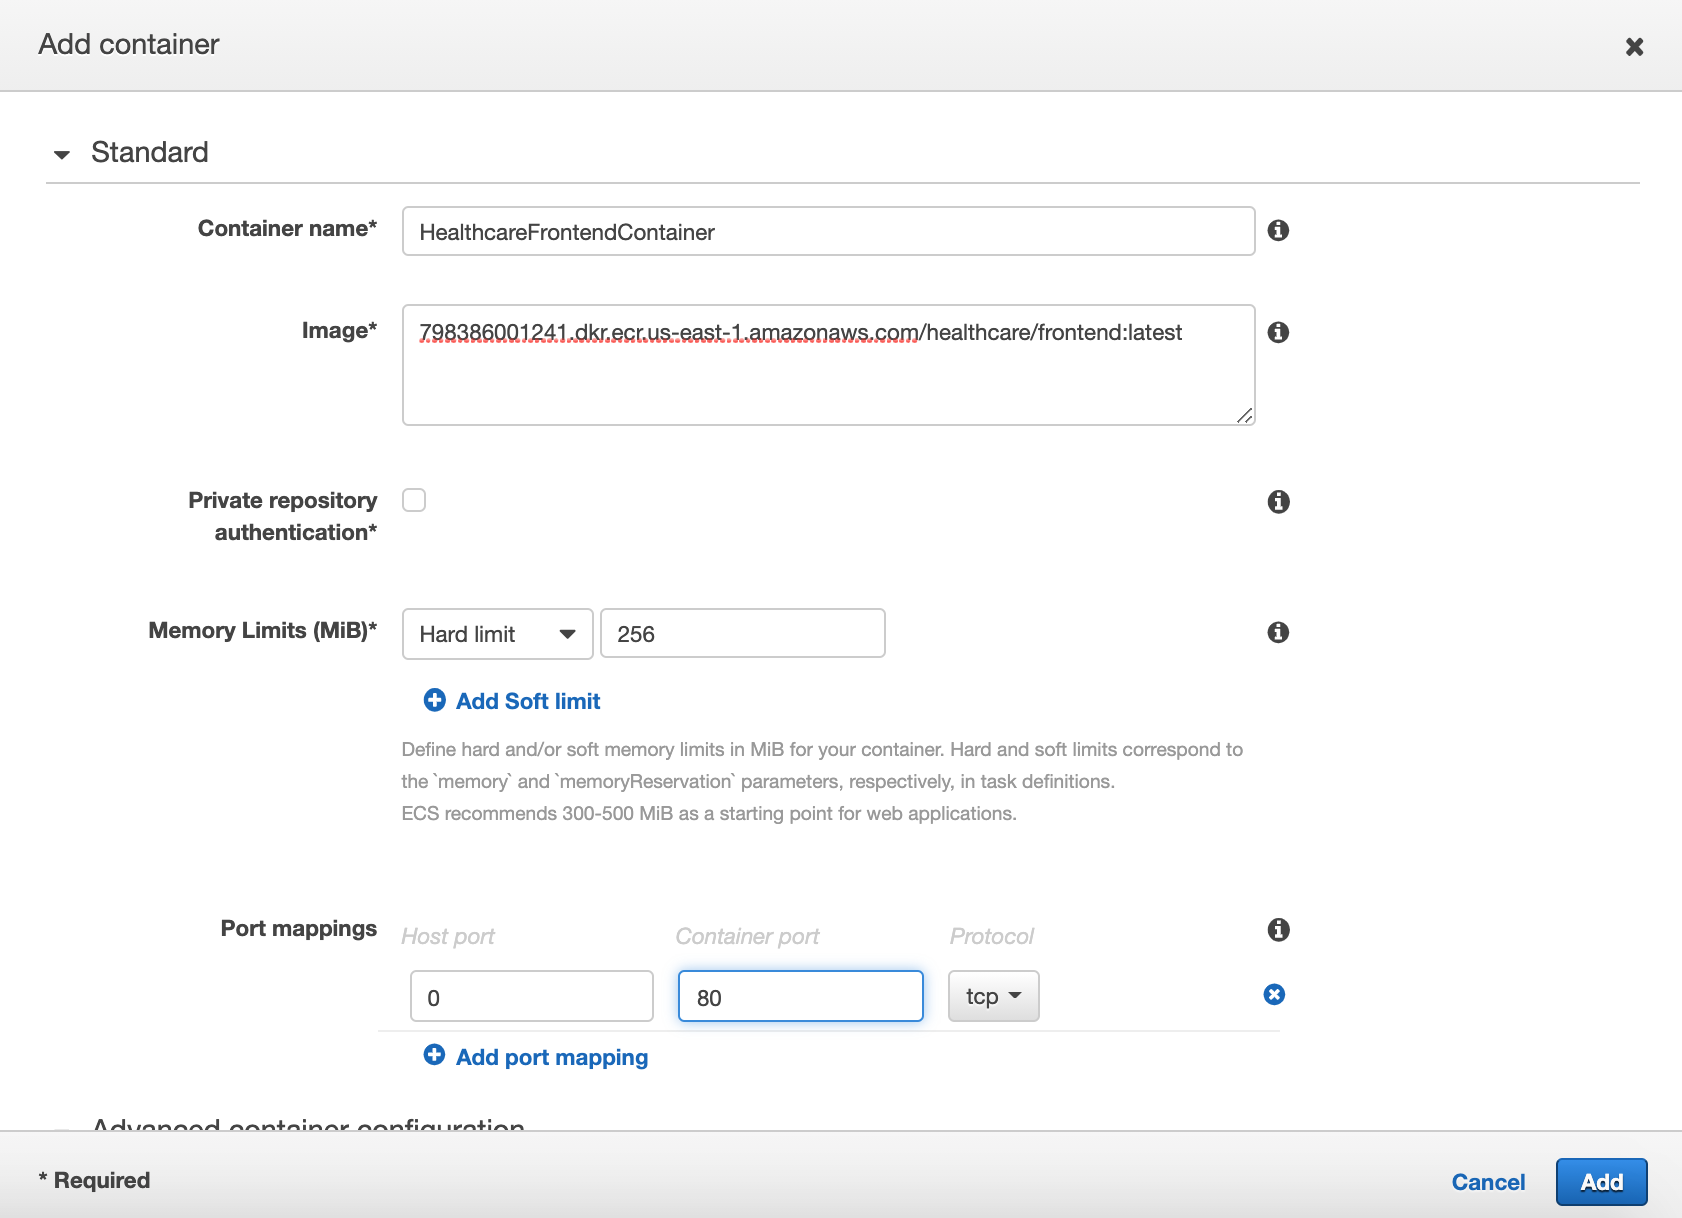


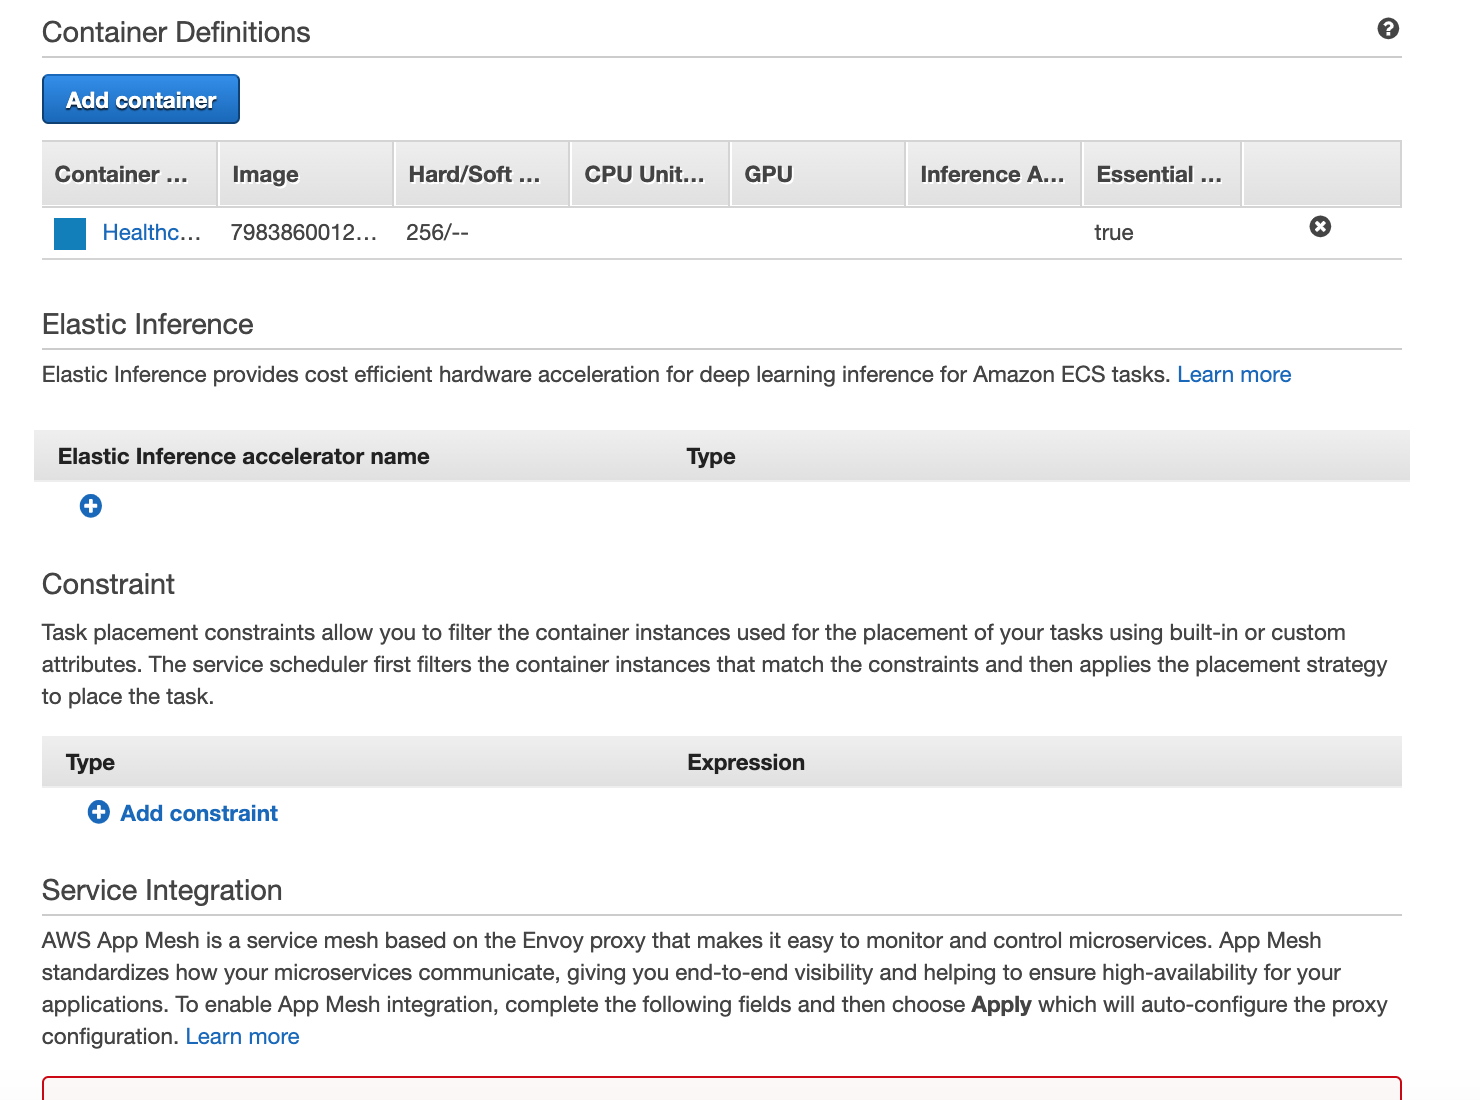


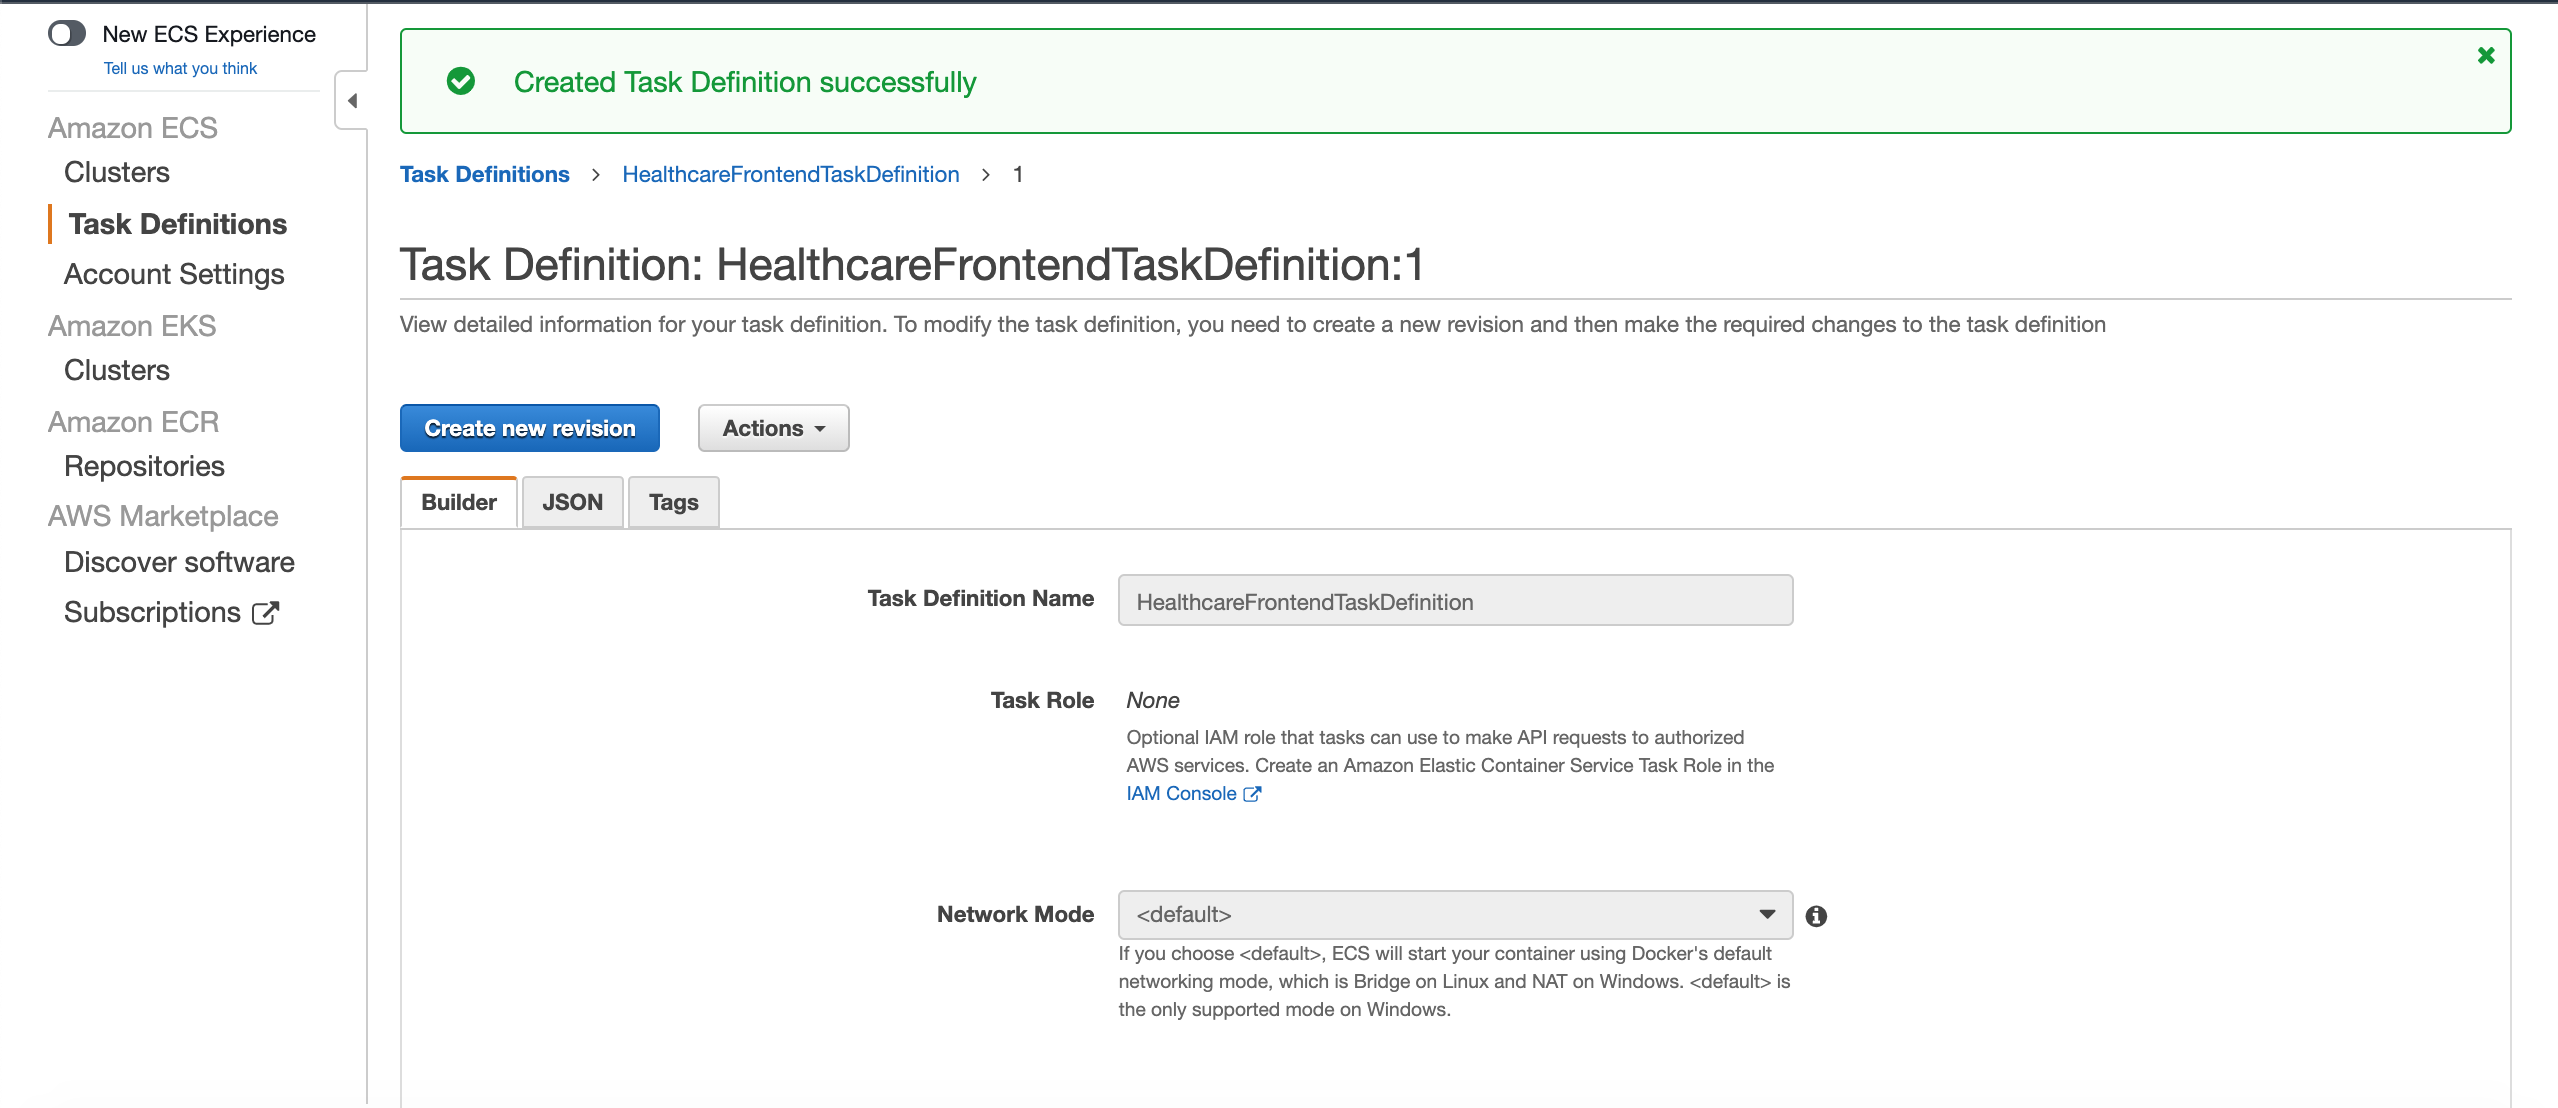

# <font color='blue'> ECS Service - Frontend </font>

Now that we have the Task Definition for our frontend application, we can go ahead and create ECS Service using the task definition and we can see 2 containers of our frontend application being spin up. Follow through the below steps in order to achieve it.

1. Go back to ECS Cluster and get into our cluster. Click on Create button in Services tab. And follow the below screenshots to create a service.

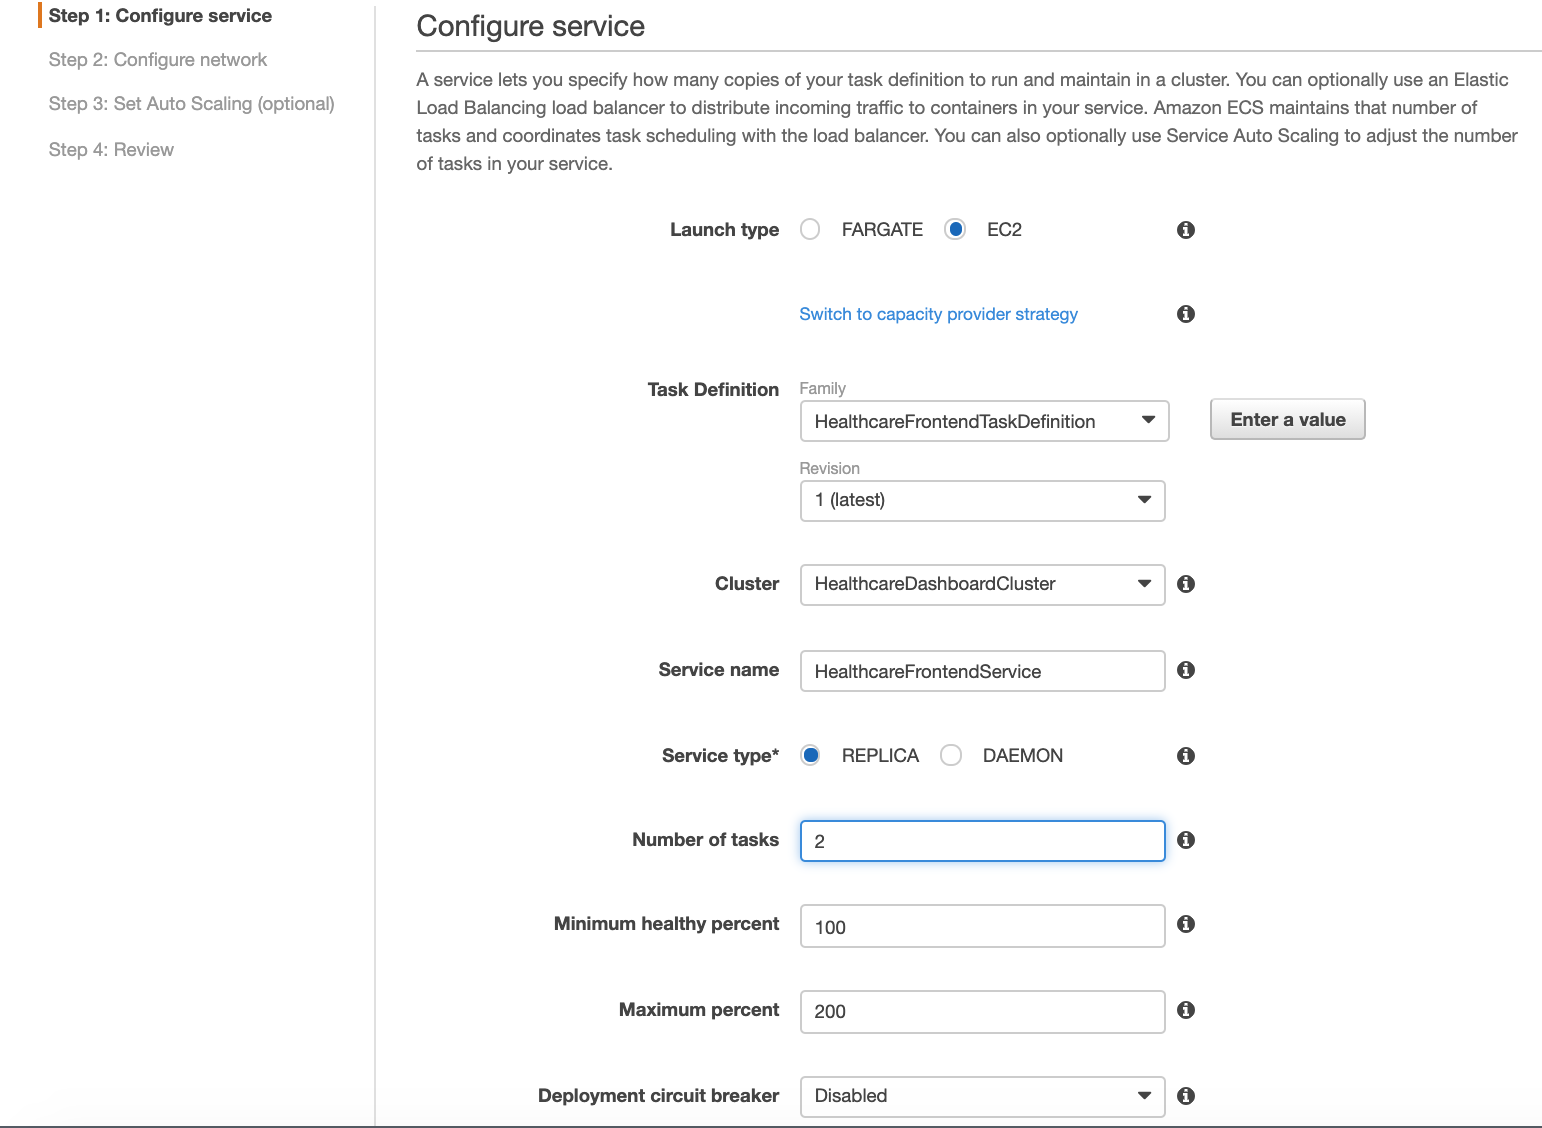


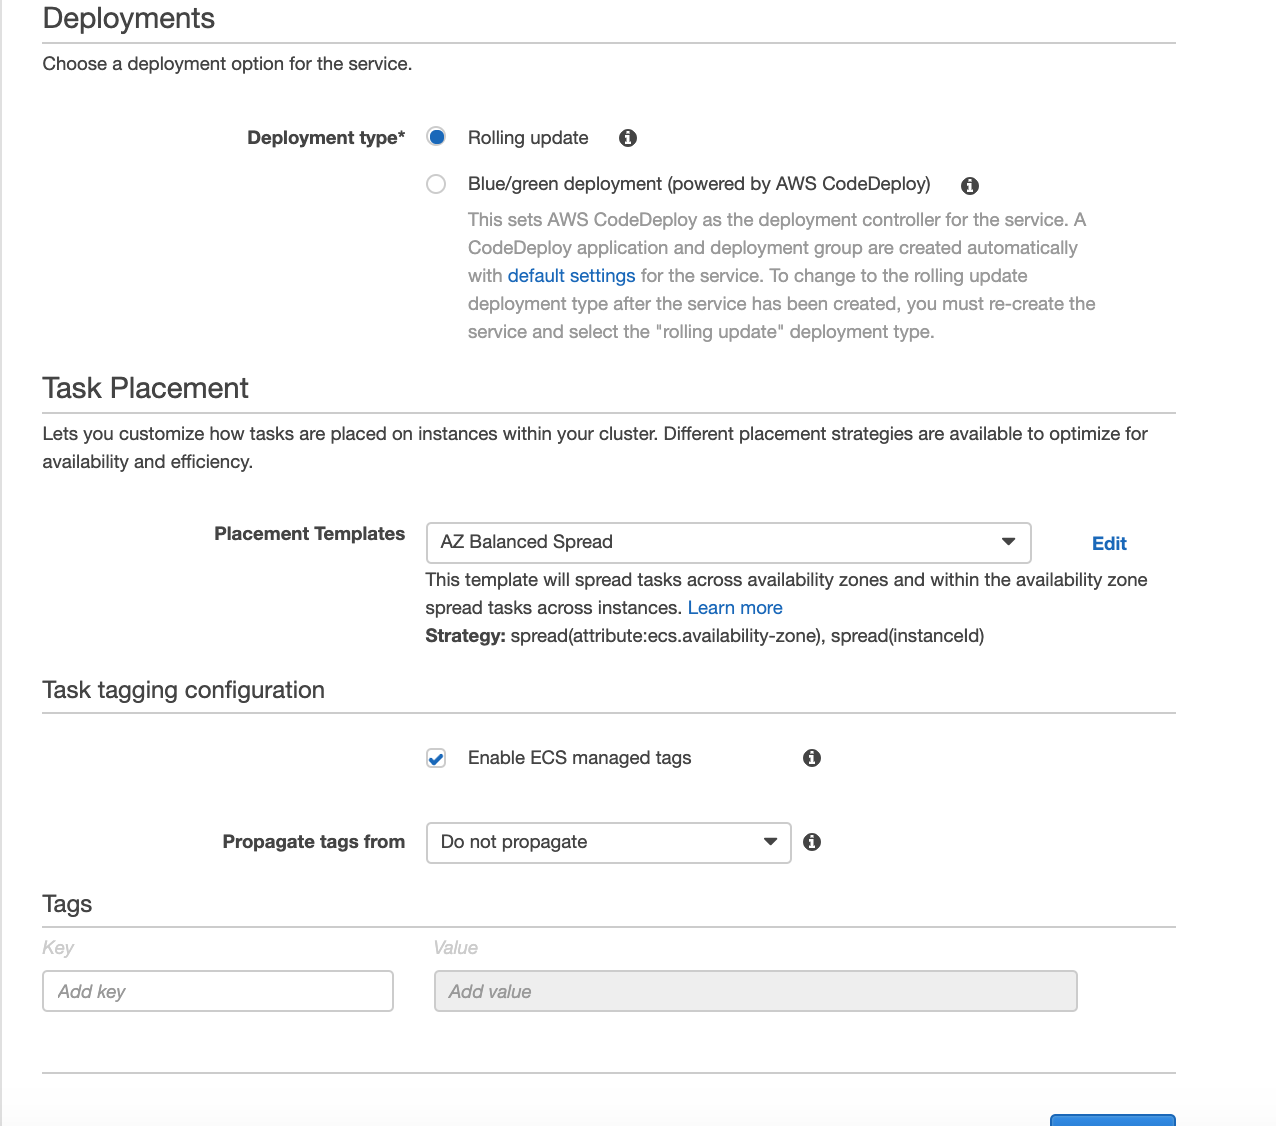


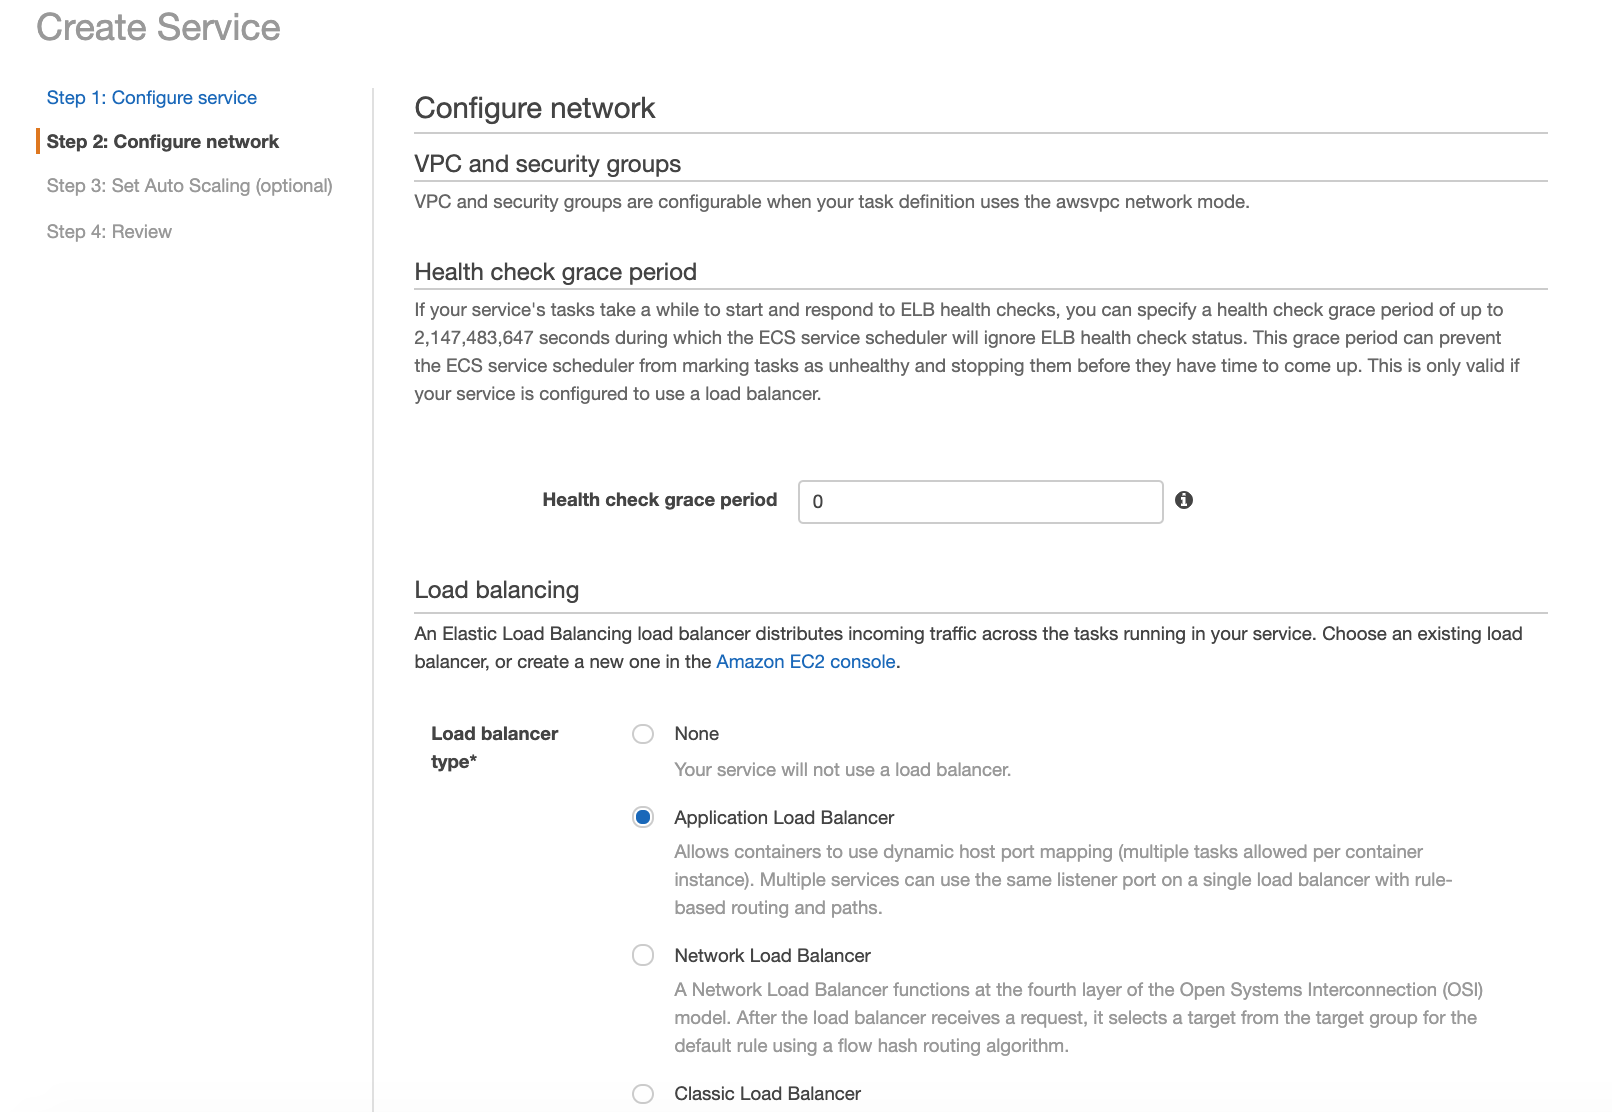


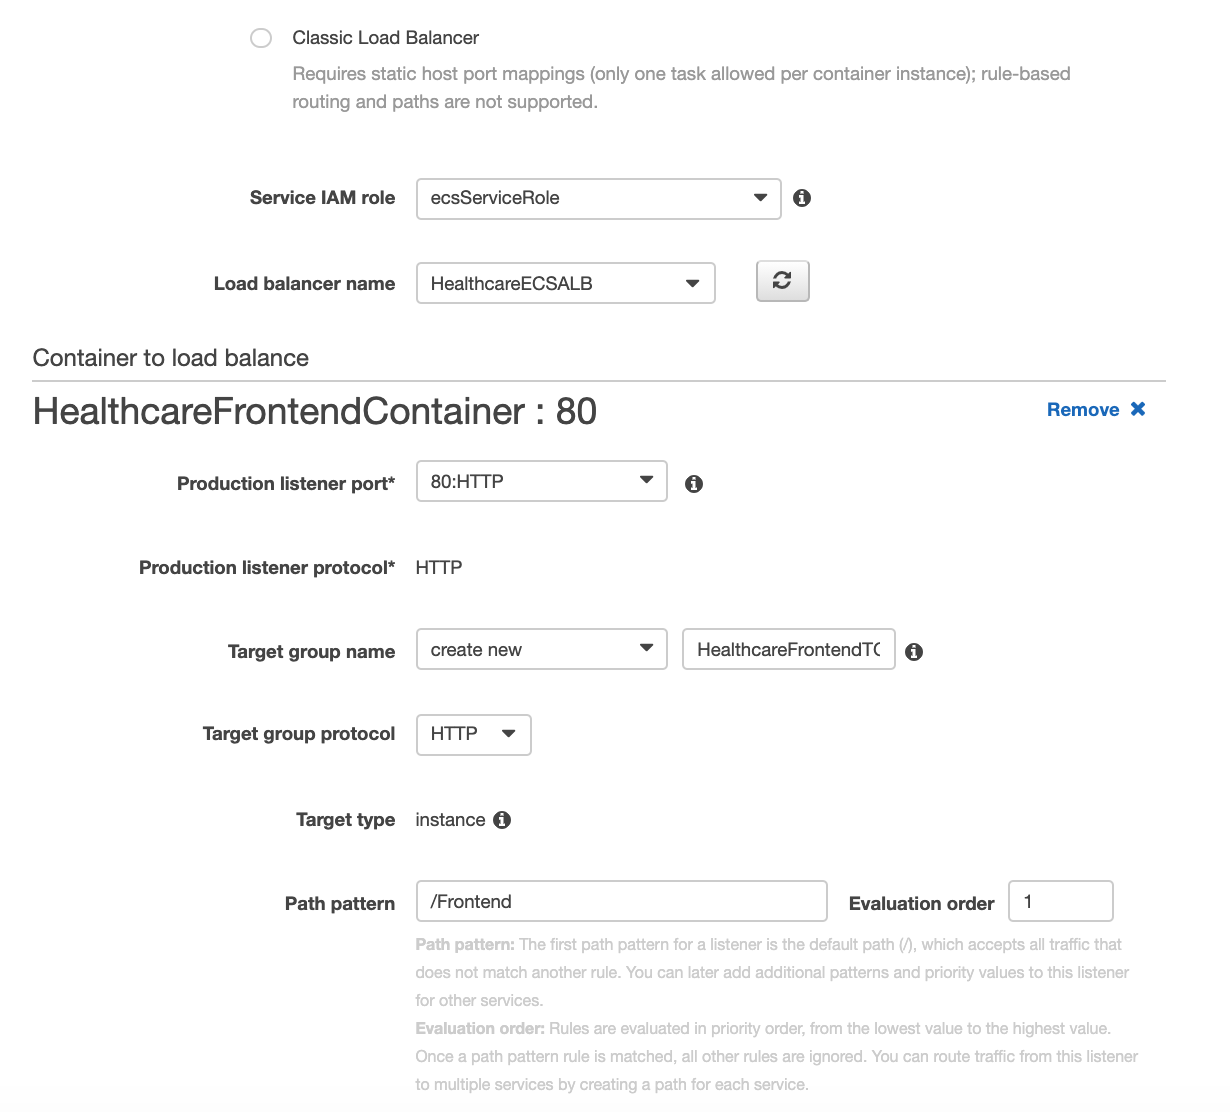


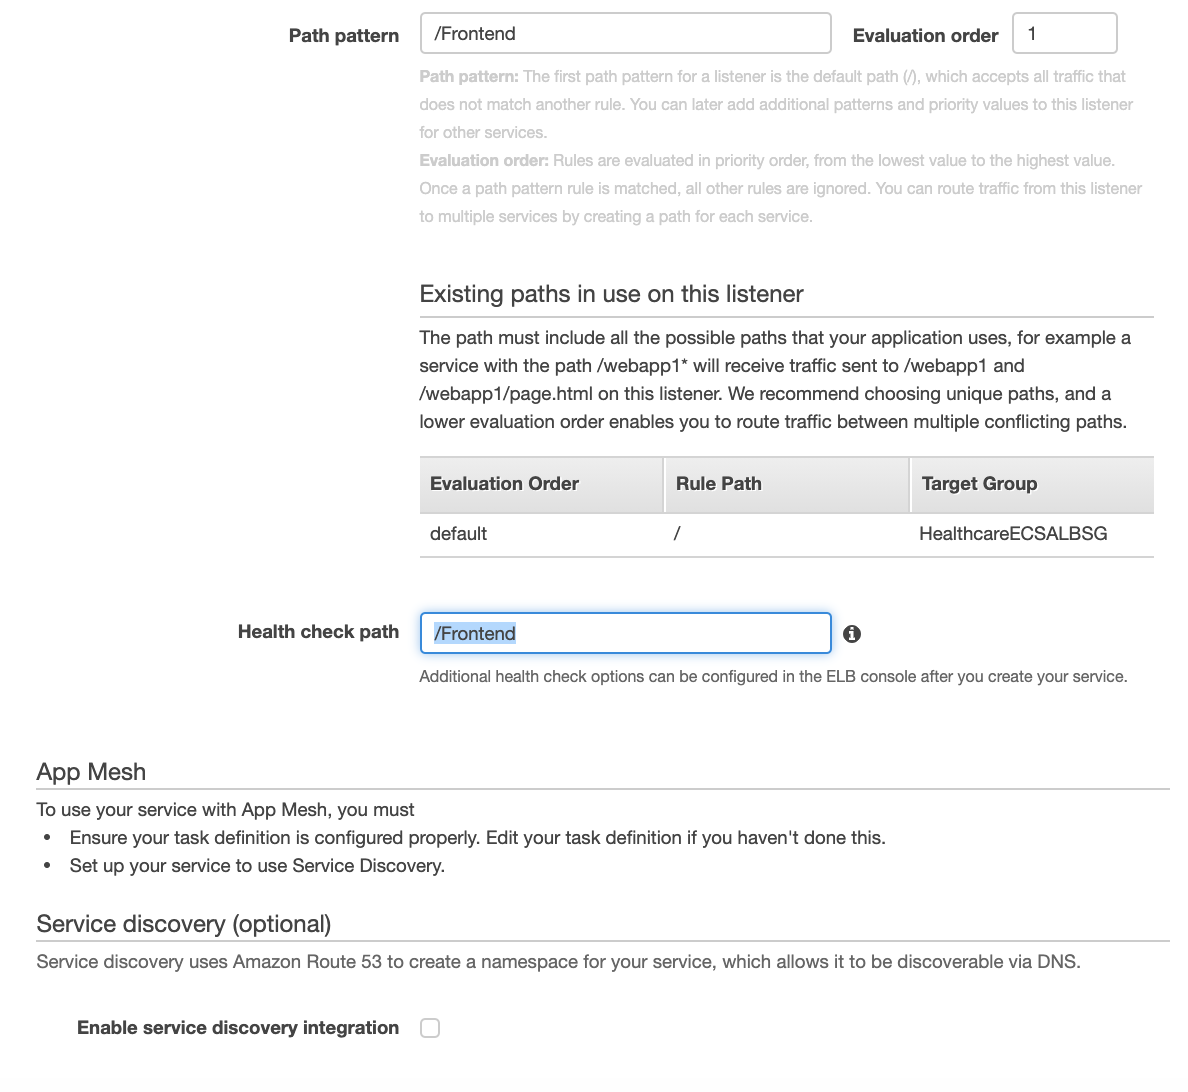


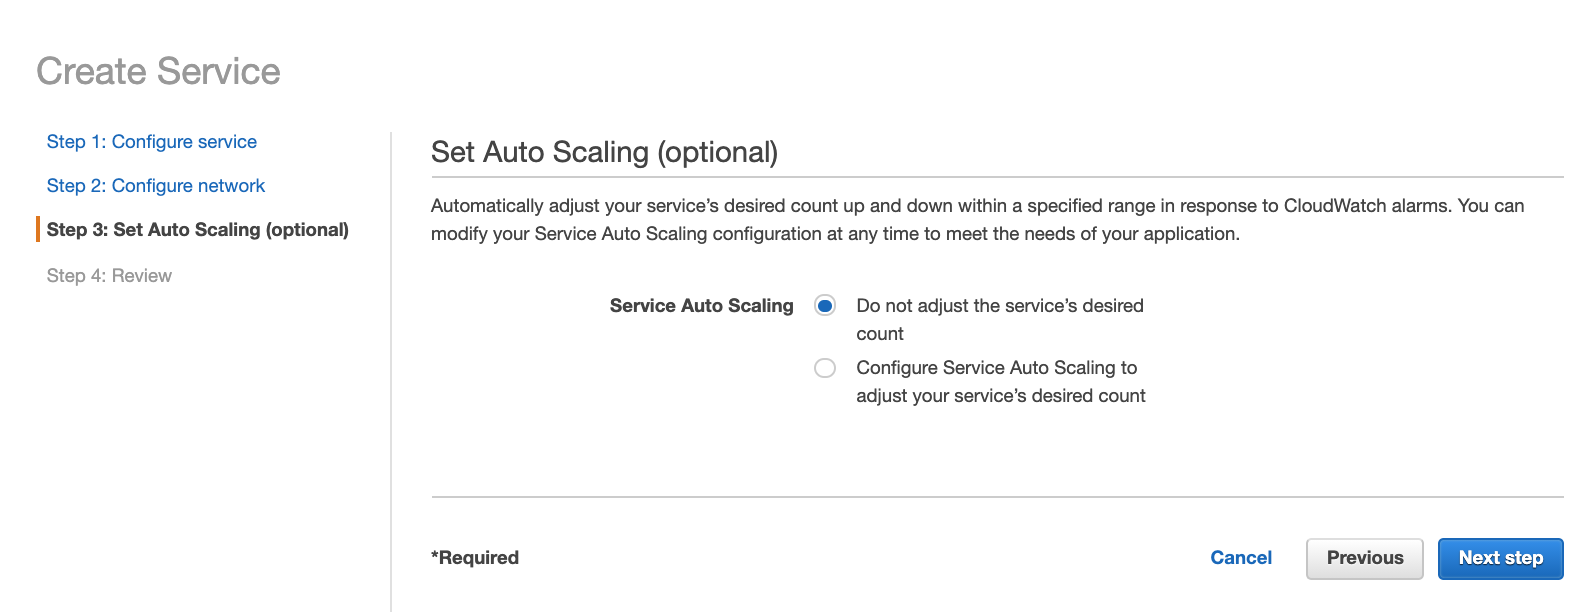



2. Once you create the ECS Service for Frontend application, we should be able to see 2 tasks being created for our frontend application as shown below.

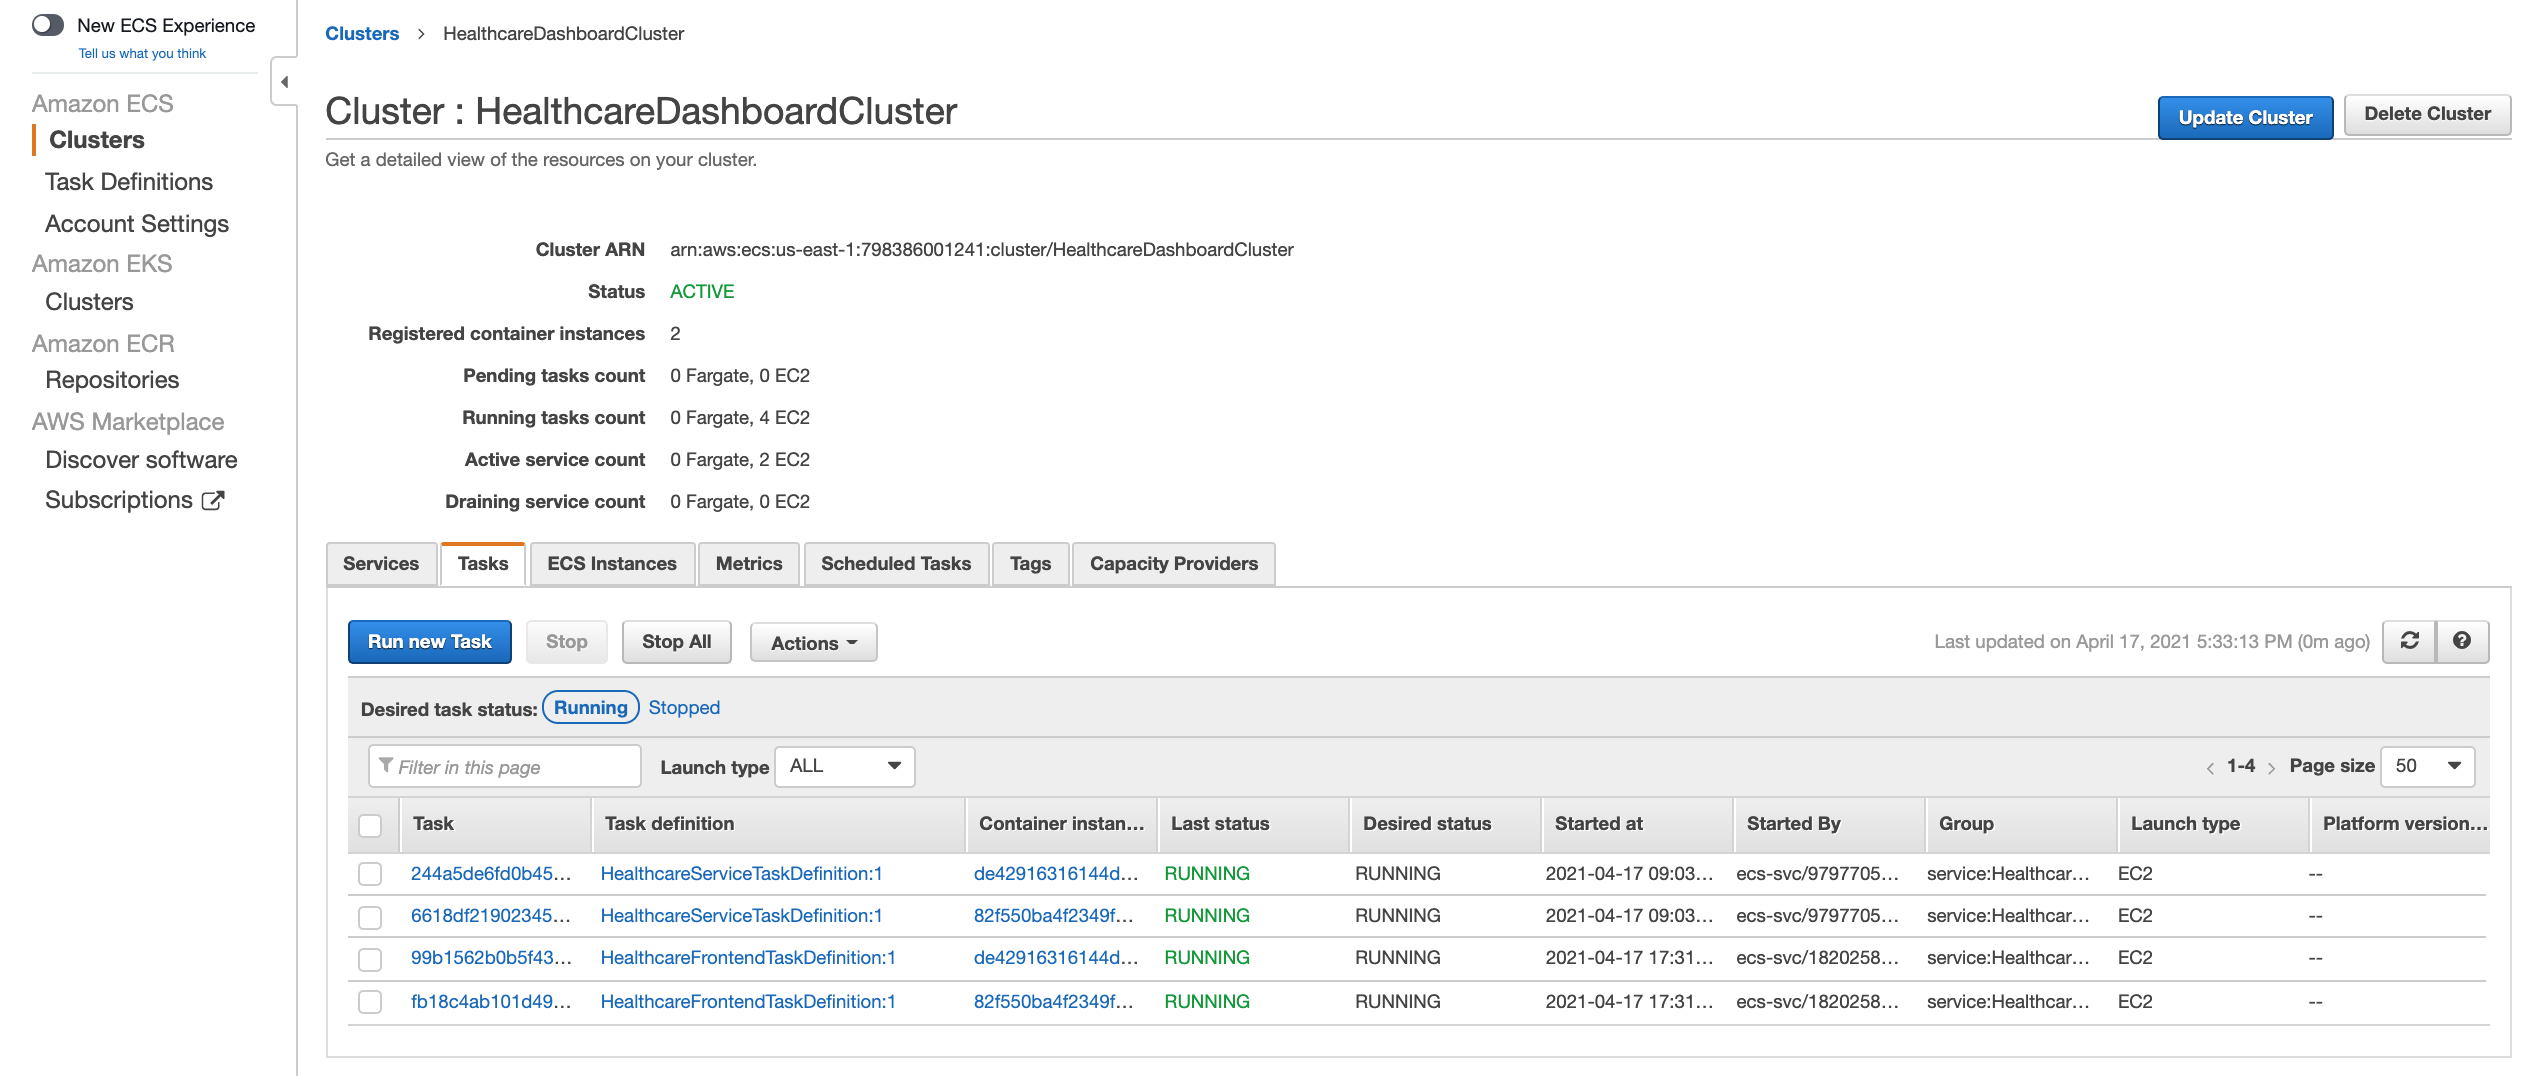



3. One last thing that we need to do is adjust the ALB listener rules so that our URL would work perfectly. We are going to enable path based routing in the ALB for both backend and frontend services. When the path is `/api/*` then we route it to backend service by forwarding the request to `HealthcareECSALBTG`, otherwise forward the request to `HealthcareFrontendTG` that we created above. Click on the add and edit button on this page to make these changes. Once done, it should look like below. Save the changes.

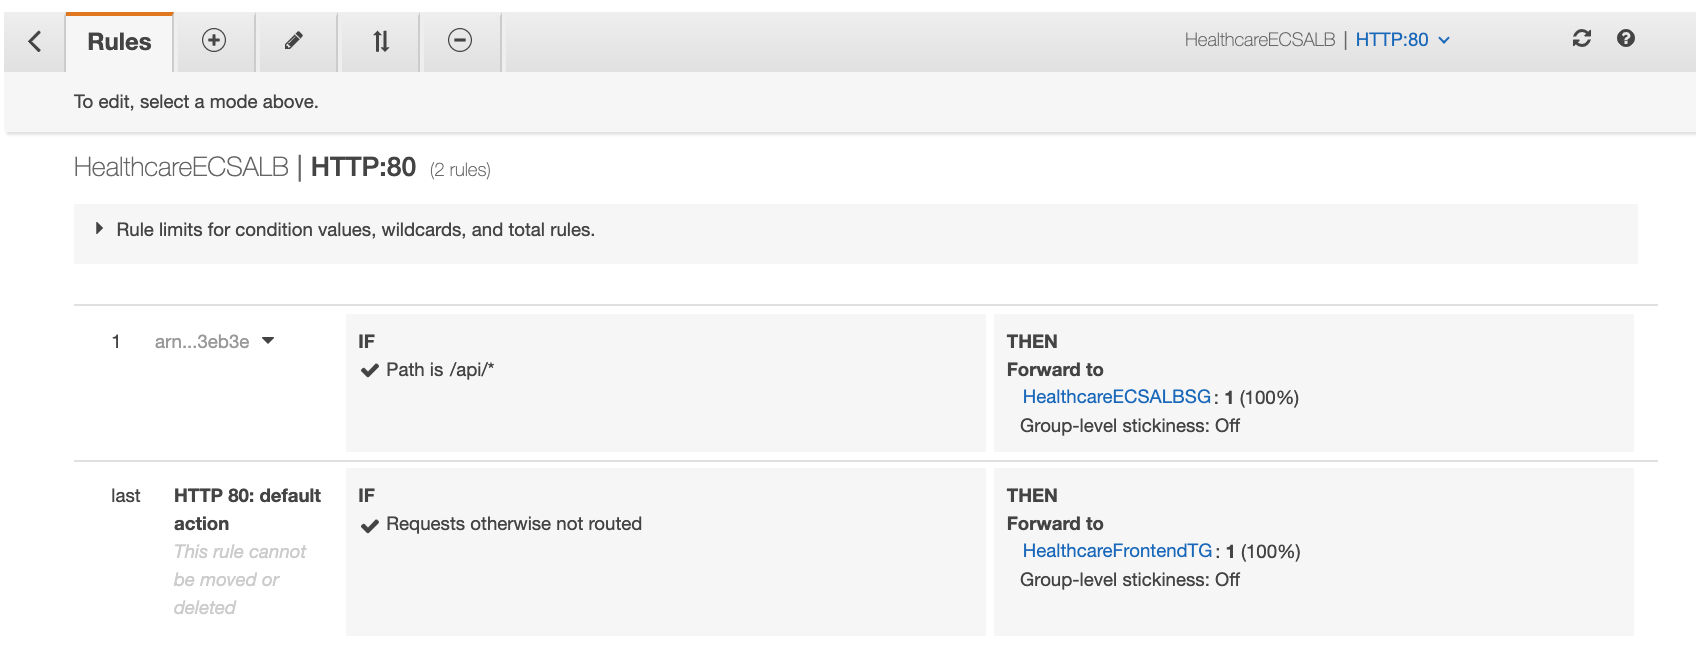

# <font color='blue'> Testing the application</font>

We have everything we need now. We should be able to access the application through the public DNS of our ALB. Please copy the public DNS of our ALB and then enter it in a browser window. We should be able to see the frontend application as below.

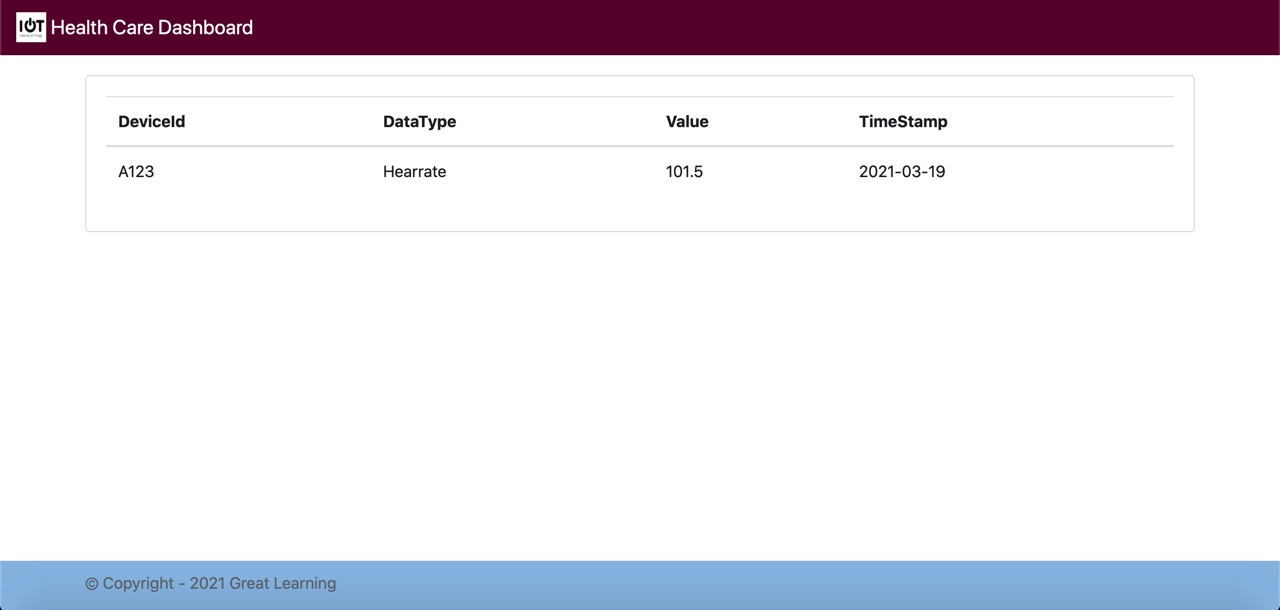

# <font color='blue'> Deploying updates </font>

If we ever want to update this application such as adding another endpoint or adding another page in our Angular application then how do we deploy those changes to the server? Let's discuss about it briefly in this section. 

1. When we make changes to the application, we need to build the docker image again. This can be for frontend or backend or both. I am going to use service as the example here.

Frontend:
<code>docker build . -t (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/frontend:latest</code>

Backend:
<code>docker build . -t (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest</code>

2. Once the docker images are built, we need to push it to ECR.

<code> aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin (awsaccountid).dkr.ecr.us-east-1.amazonaws.com </code>
    
<code> docker push (awsaccountid).dkr.ecr.us-east-1.amazonaws.com/healthcare/service:latest </code>

3. Once the docker images are pushed to ECR, We need to carry out a rolling update deployment in ECS, you follow these two steps:
  *   Register a new task definition using the AWS ECS register-task-definition command or using AWS Console.
  *   Launch a service update using the AWS ECS update-service command or using AWS Console.

4. ECS then restarts all tasks, honoring the minimum healthy percent parameter. This ensures a zero-downtime deployment.

# <font color='blue'> Scaling the application</font>

Saling the application is super easy in ECS since we have autoscaling feature in ECS Service. Once you define auto configuration then ECS will take care of scaling up and down automatically.